In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm 
import pylab as py 
import datetime
import matplotlib as mpl
import seaborn as sns
from pandas.api.types import CategoricalDtype
from statsmodels.graphics.tsaplots import plot_pacf
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from time import time
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

datasetDL = pd.read_csv("serie-storiche-ecommerce.csv", sep =",")
pd.set_option('display.max_rows', None)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# PRE-PROCESSING

In [ ]:
datasetDL.index.name = "data"
#print(datasetDL.index.name)
datasetDL["totale"] = datasetDL["data"] + "." + datasetDL["totale"] #unione delle colonne in quanto l'import del dataset riscontra dei problemi 
datasetDL["totale"]= datasetDL["totale"].str.replace("'","")
datasetDL=datasetDL.drop(columns="data")
#display(datasetDL)

In [ ]:
x = datasetDL["settore"].unique() #inserimento nell'array dei possibili settori
x=x.tolist() #trasformazione da array a lista
index=15 #in posizione 15 c'è il valore Nan che deve essere eliminato
x.pop(index) #viene eliminato il valore Nan 
#print(x)

#ciclo per sistemare i valori che contengono Nan andando ad inserire il Settore e il Totale corretto 
for index, row in datasetDL.iterrows():
    if (row['settore'] not in x):
            row['settore'] = row['totale'].split('.')[1]
            row['totale'] = row['totale'].split('.')[0]
datasetDL["totale"]=datasetDL["totale"].astype(float)
datasetDL = datasetDL.reset_index()
#display(datasetDL) 

In [ ]:
dataPesca = datasetDL[datasetDL['settore'] == "Pesca"]

In [ ]:
dataRt1 = pd.read_csv('iss_rt_italia.csv', sep = ",")
#dataRt1 = dataRt1.iloc[268:350]
dataRt1 = dataRt1.drop(columns=['rt_positivi_err68perc', 'rt_sintomatici', 'rt_sintomatici_err68perc'])
dataRt1 = dataRt1.set_index('data')
dataRt1.index = pd.to_datetime(dataRt1.index)
# dataRt1

# dataRt1Week = dataRt1
# dataRt1Week = dataRt1Week.groupby(pd.Grouper(freq='W-MON')).last()
# print(dataRt1Week)

In [ ]:
dataPesca = dataPesca.reset_index()
dataPesca = dataPesca.drop(columns =['index', 'settore'])
# print(dataPesca)

In [ ]:
dataPesca = dataPesca.set_index('data')
dataPesca.index = pd.to_datetime(dataPesca.index)
# print(dataPesca)

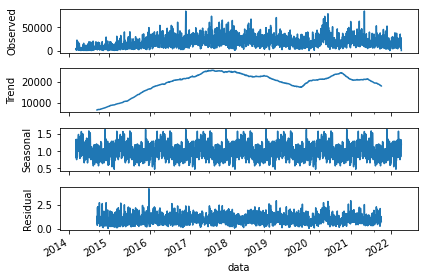

In [ ]:
# Error/Trend/Seasonality Models
N = 38
dataPesca2 = dataPesca.iloc[N:]
# print(dataPesca2)
# dataPesca2 = dataPesca2.drop(columns = ['year', 'month'])
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(dataPesca2['totale'], model='multiplicative', freq=365)  # model='mul' also works
result.plot();

Stazionarietà del dataset -- AGGIUNGERE TEST COERENTE CON QUELLO DI AUTO ARIMA (ovvero kpss)

SEASONALITY --> fare test ocsb

In [ ]:
# import pmdarima
# result = OCSBTest(dataPesca['totale'].dropna(), 365)
# print(result)

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [ ]:
adf_test(dataPesca['totale'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -3.626451
p-value                    0.005275
# lags used               28.000000
# observations          2949.000000
critical value (1%)       -3.432569
critical value (5%)       -2.862521
critical value (10%)      -2.567292
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


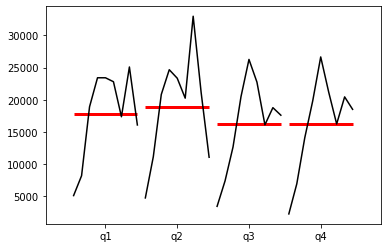

In [ ]:
from statsmodels.graphics.tsaplots import quarter_plot
dfq = dataPesca['totale'].resample(rule='Q').mean()

quarter_plot(dfq);

In [ ]:
dataPesca=dataPesca.reset_index()
# print(dataPesca)

# PROPHET

In [ ]:
from fbprophet import Prophet
import holidays

dataPesca.columns = ['ds','y']
dataPesca['ds'] = pd.to_datetime(dataPesca['ds'])

In [ ]:
train = dataPesca.iloc[:2881]
test = dataPesca.iloc[-2881:]

In [ ]:
from statsmodels.tools.eval_measures import rmse


import warnings
warnings.filterwarnings("ignore")

def rollingDaysProphet(data, train_end, window, iter = 10):

  rmseList = list()
  

  for i in range(iter):
    m = Prophet()
    train_data = data[:train_end]
    test_end = train_end + window
    test_data = data[train_end:test_end]
    train_end += 1

    m.fit(train_data)
    future = m.make_future_dataframe(periods=window,freq='D')
    forecast = m.predict(future)
    predictions = forecast.iloc[-window:]['yhat']

    print("predictions")
    print(predictions)

    print("test data")
    print(test_data['y'])

    # num = np.sum(np.square(test_data['y'] - predictions))
    # den = np.sum(np.square(predictions))
    # squared_error = num/den
    # rrmse_loss = np.sqrt(squared_error)
    EPSILON =  1e-10
    rmspe = (np.sqrt(np.mean(np.square((test_data['y'] - predictions) / (test_data['y'] + EPSILON))))) * 100
    rmseList.append(rmspe)

  return rmseList

In [ ]:
train_end = 2881
rmseProphet = rollingDaysProphet(dataPesca,train_end, 1, 14)
print(rmseProphet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2881    14247.758788
Name: yhat, dtype: float64
test data
2881    11297.79
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2882    17127.194544
Name: yhat, dtype: float64
test data
2882    16108.74
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2883    23378.820437
Name: yhat, dtype: float64
test data
2883    19279.02
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2884    22197.822638
Name: yhat, dtype: float64
test data
2884    9741.71
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2885    20363.598279
Name: yhat, dtype: float64
test data
2885    16135.76
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2886    18447.65582
Name: yhat, dtype: float64
test data
2886    10244.94
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2887    17832.652163
Name: yhat, dtype: float64
test data
2887    9722.34
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2888    16530.881002
Name: yhat, dtype: float64
test data
2888    14676.29
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2889    19483.266178
Name: yhat, dtype: float64
test data
2889    28435.36
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2890    25739.811005
Name: yhat, dtype: float64
test data
2890    13440.87
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2891    24445.721449
Name: yhat, dtype: float64
test data
2891    11067.19
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2892    22218.561637
Name: yhat, dtype: float64
test data
2892    14973.75
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2893    20432.593897
Name: yhat, dtype: float64
test data
2893    15922.62
Name: y, dtype: float64
predictions
2894    19964.8911
Name: yhat, dtype: float64
test data
2894    16044.88
Name: y, dtype: float64
[26.111025145057898, 6.3223724748385095, 21.265606014701415, 127.8637183613128, 26.201668089577613, 80.06602108183995, 83.41934311129852, 12.636647285850119, 31.48225948980306, 91.50405446275848, 120.88462788523005, 48.38341522348679, 28.324320350796235, 24.431538905304958]


In [ ]:
print(test)

             ds         y
97   2014-05-06   4964.32
98   2014-05-07  12885.38
99   2014-05-08   4217.12
100  2014-05-09    586.19
101  2014-05-10   1210.86
102  2014-05-11   5218.39
103  2014-05-12  15941.45
104  2014-05-13   5929.30
105  2014-05-14   3115.97
106  2014-05-15   3100.96
107  2014-05-16   3075.04
108  2014-05-17   1496.04
109  2014-05-18   1802.78
110  2014-05-19  10946.84
111  2014-05-20   5889.73
112  2014-05-22   2123.71
113  2014-05-23    630.40
114  2014-05-24    900.57
115  2014-05-25   1257.52
116  2014-05-26   9279.83
117  2014-05-27    638.59
118  2014-05-28   4659.22
119  2014-05-29   3507.04
120  2014-05-30   1329.98
121  2014-05-31   3514.68
122  2014-06-01  11915.09
123  2014-06-02   1760.48
124  2014-06-03   5373.67
125  2014-06-04   2114.98
126  2014-06-05   1890.65
127  2014-06-06   2573.99
128  2014-06-07    557.53
129  2014-06-08   2510.41
130  2014-06-09   5500.85
131  2014-06-10   8797.20
132  2014-06-11   4540.24
133  2014-06-12  10777.09
134  2014-06

Prophet con variabile esogena relativa ai saldi

In [ ]:
# from fbprophet import Prophet
# import holidays

# dataPesca.columns = ['ds','y']
# dataPesca['ds'] = pd.to_datetime(dataPesca['ds'])

In [ ]:
# train = dataPesca.iloc[:2881]
# test = dataPesca.iloc[-2881:]

In [ ]:
saldiInv = pd.DataFrame({
  'holiday': 'saldiInv',
  'ds': pd.to_datetime(['2014-01-04', '2014-01-05', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-11',
               '2014-01-12', '2014-01-13', '2014-01-14', '2014-01-15',
               '2014-01-16', '2014-01-17', '2014-01-18', '2014-01-19',
               '2014-01-20', '2014-01-21', '2014-01-22', '2014-01-23',
               '2014-01-24', '2014-01-25', '2014-01-26', '2014-01-27',
               '2014-01-28', '2014-01-29', '2014-01-30', '2014-01-31',
               '2014-02-01', '2014-02-02', '2014-02-03', '2014-02-04',
               '2014-02-05', '2014-02-06', '2014-02-07', '2014-02-08',
               '2014-02-09', '2014-02-10', '2014-02-11', '2014-02-12',
               '2014-02-13', '2014-02-14', '2014-02-15', '2014-02-16',
               '2014-02-17', '2014-02-18', '2014-02-19', '2014-02-20',
               '2014-02-21', '2014-02-22', '2014-02-23', '2014-02-24',
               '2014-02-25', '2014-02-26', '2014-02-27', '2014-02-28',
               '2014-03-01', '2014-03-02', '2014-03-03', '2014-03-04',
               '2014-03-05', 
               '2015-01-03', '2015-01-04', '2015-01-05', '2015-01-06',
               '2015-01-07', '2015-01-08', '2015-01-09', '2015-01-10',
               '2015-01-11', '2015-01-12', '2015-01-13', '2015-01-14',
               '2015-01-15', '2015-01-16', '2015-01-17', '2015-01-18',
               '2015-01-19', '2015-01-20', '2015-01-21', '2015-01-22',
               '2015-01-23', '2015-01-24', '2015-01-25', '2015-01-26',
               '2015-01-27', '2015-01-28', '2015-01-29', '2015-01-30',
               '2015-01-31', '2015-02-01', '2015-02-02', '2015-02-03',
               '2015-02-04', '2015-02-05', '2015-02-06', '2015-02-07',
               '2015-02-08', '2015-02-09', '2015-02-10', '2015-02-11',
               '2015-02-12', '2015-02-13', '2015-02-14', '2015-02-15',
               '2015-02-16', '2015-02-17', '2015-02-18', '2015-02-19',
               '2015-02-20', '2015-02-21', '2015-02-22', '2015-02-23',
               '2015-02-24', '2015-02-25', '2015-02-26', '2015-02-27',
               '2015-02-28', '2015-03-01', '2015-03-02', '2015-03-03',
               '2015-03-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10', '2016-01-11', '2016-01-12',
               '2016-01-13', '2016-01-14', '2016-01-15', '2016-01-16',
               '2016-01-17', '2016-01-18', '2016-01-19', '2016-01-20',
               '2016-01-21', '2016-01-22', '2016-01-23', '2016-01-24',
               '2016-01-25', '2016-01-26', '2016-01-27', '2016-01-28',
               '2016-01-29', '2016-01-30', '2016-01-31', '2016-02-01',
               '2016-02-02', '2016-02-03', '2016-02-04', '2016-02-05',
               '2016-02-06', '2016-02-07', '2016-02-08', '2016-02-09',
               '2016-02-10', '2016-02-11', '2016-02-12', '2016-02-13',
               '2016-02-14', '2016-02-15', '2016-02-16', '2016-02-17',
               '2016-02-18', '2016-02-19', '2016-02-20', '2016-02-21',
               '2016-02-22', '2016-02-23', '2016-02-24', '2016-02-25',
               '2016-02-26', '2016-02-27', '2016-02-28', '2016-02-29',
               '2016-03-01', '2016-03-02', '2016-03-03', '2016-03-04',
               '2016-03-05',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-14', '2017-01-15', '2017-01-16',
               '2017-01-17', '2017-01-18', '2017-01-19', '2017-01-20',
               '2017-01-21', '2017-01-22', '2017-01-23', '2017-01-24',
               '2017-01-25', '2017-01-26', '2017-01-27', '2017-01-28',
               '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01',
               '2017-02-02', '2017-02-03', '2017-02-04', '2017-02-05',
               '2017-02-06', '2017-02-07', '2017-02-08', '2017-02-09',
               '2017-02-10', '2017-02-11', '2017-02-12', '2017-02-13',
               '2017-02-14', '2017-02-15', '2017-02-16', '2017-02-17',
               '2017-02-18', '2017-02-19', '2017-02-20', '2017-02-21',
               '2017-02-22', '2017-02-23', '2017-02-24', '2017-02-25',
               '2017-02-26', '2017-02-27', '2017-02-28', '2017-03-01',
               '2017-03-02', '2017-03-03', '2017-03-04', '2017-03-05',             
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10', '2018-01-11', '2018-01-12',
               '2018-01-13', '2018-01-14', '2018-01-15', '2018-01-16',
               '2018-01-17', '2018-01-18', '2018-01-19', '2018-01-20',
               '2018-01-21', '2018-01-22', '2018-01-23', '2018-01-24',
               '2018-01-25', '2018-01-26', '2018-01-27', '2018-01-28',
               '2018-01-29', '2018-01-30', '2018-01-31', '2018-02-01',
               '2018-02-02', '2018-02-03', '2018-02-04', '2018-02-05',
               '2018-02-06', '2018-02-07', '2018-02-08', '2018-02-09',
               '2018-02-10', '2018-02-11', '2018-02-12', '2018-02-13',
               '2018-02-14', '2018-02-15', '2018-02-16', '2018-02-17',
               '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21',
               '2018-02-22', '2018-02-23', '2018-02-24', '2018-02-25',
               '2018-02-26', '2018-02-27', '2018-02-28', '2018-03-01',
               '2018-03-02', '2018-03-03', '2018-03-04', '2018-03-05',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10', '2019-01-11', '2019-01-12',
               '2019-01-13', '2019-01-14', '2019-01-15', '2019-01-16',
               '2019-01-17', '2019-01-18', '2019-01-19', '2019-01-20',
               '2019-01-21', '2019-01-22', '2019-01-23', '2019-01-24',
               '2019-01-25', '2019-01-26', '2019-01-27', '2019-01-28',
               '2019-01-29', '2019-01-30', '2019-01-31', '2019-02-01',
               '2019-02-02', '2019-02-03', '2019-02-04', '2019-02-05',
               '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09',
               '2019-02-10', '2019-02-11', '2019-02-12', '2019-02-13',
               '2019-02-14', '2019-02-15', '2019-02-16', '2019-02-17',
               '2019-02-18', '2019-02-19', '2019-02-20', '2019-02-21',
               '2019-02-22', '2019-02-23', '2019-02-24', '2019-02-25',
               '2019-02-26', '2019-02-27', '2019-02-28', '2019-03-01',
               '2019-03-02', '2019-03-03', '2019-03-04', '2019-03-05',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10', '2020-01-11', '2020-01-12',
               '2020-01-13', '2020-01-14', '2020-01-15', '2020-01-16',
               '2020-01-17', '2020-01-18', '2020-01-19', '2020-01-20',
               '2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24',
               '2020-01-25', '2020-01-26', '2020-01-27', '2020-01-28',
               '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-01',
               '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05',
               '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-09',
               '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13',
               '2020-02-14', '2020-02-15', '2020-02-16', '2020-02-17',
               '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21',
               '2020-02-22', '2020-02-23', '2020-02-24', '2020-02-25',
               '2020-02-26', '2020-02-27', '2020-02-28', '2020-02-29',
               '2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05'
              #  '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
              #  '2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12',
              #  '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16',
              #  '2021-01-17', '2021-01-18', '2021-01-19', '2021-01-20',
              #  '2021-01-21', '2021-01-22', '2021-01-23', '2021-01-24',
              #  '2021-01-25', '2021-01-26', '2021-01-27', '2021-01-28',
              #  '2021-01-29', '2021-01-30', '2021-01-31', '2021-02-01',
              #  '2021-02-02', '2021-02-03', '2021-02-04', '2021-02-05',
              #  '2021-02-06', '2021-02-07', '2021-02-08', '2021-02-09',
              #  '2021-02-10', '2021-02-11', '2021-02-12', '2021-02-13',
              #  '2021-02-14', '2021-02-15', '2021-02-16', '2021-02-17',
              #  '2021-02-18', '2021-02-19', '2021-02-20', '2021-02-21',
              #  '2021-02-22', '2021-02-23', '2021-02-24', '2021-02-25',
              #  '2021-02-26', '2021-02-27', '2021-02-28', '2021-03-01',
              #  '2021-03-02', '2021-03-03', '2021-03-04', '2021-03-05',
              #  '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
              #  '2022-01-09', '2022-01-10', '2022-01-11', '2022-01-12',
              #  '2022-01-13', '2022-01-14', '2022-01-15', '2022-01-16',
              #  '2022-01-17', '2022-01-18', '2022-01-19', '2022-01-20',
              #  '2022-01-21', '2022-01-22', '2022-01-23', '2022-01-24',
              #  '2022-01-25', '2022-01-26', '2022-01-27', '2022-01-28',
              #  '2022-01-29', '2022-01-30', '2022-01-31', '2022-02-01',
              #  '2022-02-02', '2022-02-03', '2022-02-04', '2022-02-05',
              #  '2022-02-06', '2022-02-07', '2022-02-08', '2022-02-09',
              #  '2022-02-10', '2022-02-11', '2022-02-12', '2022-02-13',
              #  '2022-02-14', '2022-02-15', '2022-02-16', '2022-02-17',
              #  '2022-02-18', '2022-02-19', '2022-02-20', '2022-02-21',
              #  '2022-02-22', '2022-02-23', '2022-02-24', '2022-02-25',
              #  '2022-02-26', '2022-02-27', '2022-02-28', '2022-03-01',
              #  '2022-03-02', '2022-03-03', '2022-03-04', '2022-03-05'
              ]),
  'lower_window': 0,
  'upper_window': 1,
})

saldiEstivi = pd.DataFrame({
  'holiday': 'saldiEstivi',
  'ds': pd.to_datetime(['2014-07-05', '2014-07-06', '2014-07-07', '2014-07-08',
               '2014-07-09', '2014-07-10', '2014-07-11', '2014-07-12',
               '2014-07-13', '2014-07-14', '2014-07-15', '2014-07-16',
               '2014-07-17', '2014-07-18', '2014-07-19', '2014-07-20',
               '2014-07-21', '2014-07-22', '2014-07-23', '2014-07-24',
               '2014-07-25', '2014-07-26', '2014-07-27', '2014-07-28',
               '2014-07-29', '2014-07-30', '2014-07-31', '2014-08-01',
               '2014-08-02', '2014-08-03', '2014-08-04', '2014-08-05',
               '2014-08-06', '2014-08-07', '2014-08-08', '2014-08-09',
               '2014-08-10', '2014-08-11', '2014-08-12', '2014-08-13',
               '2014-08-14', '2014-08-15', '2014-08-16', '2014-08-17',
               '2014-08-18', '2014-08-19', '2014-08-20', '2014-08-21',
               '2014-08-22', '2014-08-23', '2014-08-24', '2014-08-25',
               '2014-08-26', '2014-08-27', '2014-08-28', '2014-08-29',
               '2014-08-30', '2014-08-31', '2014-09-01', '2014-09-02',
               '2014-09-03', 
               '2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07',
               '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11',
               '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15',
               '2015-07-16', '2015-07-17', '2015-07-18', '2015-07-19',
               '2015-07-20', '2015-07-21', '2015-07-22', '2015-07-23',
               '2015-07-24', '2015-07-25', '2015-07-26', '2015-07-27',
               '2015-07-28', '2015-07-29', '2015-07-30', '2015-07-31',
               '2015-08-01', '2015-08-02', '2015-08-03', '2015-08-04',
               '2015-08-05', '2015-08-06', '2015-08-07', '2015-08-08',
               '2015-08-09', '2015-08-10', '2015-08-11', '2015-08-12',
               '2015-08-13', '2015-08-14', '2015-08-15', '2015-08-16',
               '2015-08-17', '2015-08-18', '2015-08-19', '2015-08-20',
               '2015-08-21', '2015-08-22', '2015-08-23', '2015-08-24',
               '2015-08-25', '2015-08-26', '2015-08-27', '2015-08-28',
               '2015-08-29', '2015-08-30', '2015-08-31', '2015-09-01',
               '2015-09-02',
               '2016-07-02', '2016-07-03', '2016-07-04', '2016-07-05',
               '2016-07-06', '2016-07-07', '2016-07-08', '2016-07-09',
               '2016-07-10', '2016-07-11', '2016-07-12', '2016-07-13',
               '2016-07-14', '2016-07-15', '2016-07-16', '2016-07-17',
               '2016-07-18', '2016-07-19', '2016-07-20', '2016-07-21',
               '2016-07-22', '2016-07-23', '2016-07-24', '2016-07-25',
               '2016-07-26', '2016-07-27', '2016-07-28', '2016-07-29',
               '2016-07-30', '2016-07-31', '2016-08-01', '2016-08-02',
               '2016-08-03', '2016-08-04', '2016-08-05', '2016-08-06',
               '2016-08-07', '2016-08-08', '2016-08-09', '2016-08-10',
               '2016-08-11', '2016-08-12', '2016-08-13', '2016-08-14',
               '2016-08-15', '2016-08-16', '2016-08-17', '2016-08-18',
               '2016-08-19', '2016-08-20', '2016-08-21', '2016-08-22',
               '2016-08-23', '2016-08-24', '2016-08-25', '2016-08-26',
               '2016-08-27', '2016-08-28', '2016-08-29', '2016-08-30',
               '2016-08-31',
               '2017-07-01', '2017-07-02', '2017-07-03', '2017-07-04',
               '2017-07-05', '2017-07-06', '2017-07-07', '2017-07-08',
               '2017-07-09', '2017-07-10', '2017-07-11', '2017-07-12',
               '2017-07-13', '2017-07-14', '2017-07-15', '2017-07-16',
               '2017-07-17', '2017-07-18', '2017-07-19', '2017-07-20',
               '2017-07-21', '2017-07-22', '2017-07-23', '2017-07-24',
               '2017-07-25', '2017-07-26', '2017-07-27', '2017-07-28',
               '2017-07-29', '2017-07-30', '2017-07-31', '2017-08-01',
               '2017-08-02', '2017-08-03', '2017-08-04', '2017-08-05',
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15', '2017-08-16', '2017-08-17',
               '2017-08-18', '2017-08-19', '2017-08-20', '2017-08-21',
               '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25',
               '2017-08-26', '2017-08-27', '2017-08-28', '2017-08-29',
               '2017-08-30',
               '2018-07-07', '2018-07-08', '2018-07-09', '2018-07-10',
               '2018-07-11', '2018-07-12', '2018-07-13', '2018-07-14',
               '2018-07-15', '2018-07-16', '2018-07-17', '2018-07-18',
               '2018-07-19', '2018-07-20', '2018-07-21', '2018-07-22',
               '2018-07-23', '2018-07-24', '2018-07-25', '2018-07-26',
               '2018-07-27', '2018-07-28', '2018-07-29', '2018-07-30',
               '2018-07-31', '2018-08-01', '2018-08-02', '2018-08-03',
               '2018-08-04', '2018-08-05', '2018-08-06', '2018-08-07',
               '2018-08-08', '2018-08-09', '2018-08-10', '2018-08-11',
               '2018-08-12', '2018-08-13', '2018-08-14', '2018-08-15',
               '2018-08-16', '2018-08-17', '2018-08-18', '2018-08-19',
               '2018-08-20', '2018-08-21', '2018-08-22', '2018-08-23',
               '2018-08-24', '2018-08-25', '2018-08-26', '2018-08-27',
               '2018-08-28', '2018-08-29', '2018-08-30', '2018-08-31',
               '2018-09-01', '2018-09-02', '2018-09-03', '2018-09-04',
               '2018-09-05',
               '2019-07-06', '2019-07-07', '2019-07-08', '2019-07-09',
               '2019-07-10', '2019-07-11', '2019-07-12', '2019-07-13',
               '2019-07-14', '2019-07-15', '2019-07-16', '2019-07-17',
               '2019-07-18', '2019-07-19', '2019-07-20', '2019-07-21',
               '2019-07-22', '2019-07-23', '2019-07-24', '2019-07-25',
               '2019-07-26', '2019-07-27', '2019-07-28', '2019-07-29',
               '2019-07-30', '2019-07-31', '2019-08-01', '2019-08-02',
               '2019-08-03', '2019-08-04', '2019-08-05', '2019-08-06',
               '2019-08-07', '2019-08-08', '2019-08-09', '2019-08-10',
               '2019-08-11', '2019-08-12', '2019-08-13', '2019-08-14',
               '2019-08-15', '2019-08-16', '2019-08-17', '2019-08-18',
               '2019-08-19', '2019-08-20', '2019-08-21', '2019-08-22',
               '2019-08-23', '2019-08-24', '2019-08-25', '2019-08-26',
               '2019-08-27', '2019-08-28', '2019-08-29', '2019-08-30',
               '2019-08-31', '2019-09-01', '2019-09-02', '2019-09-03',
               '2020-07-01', '2020-07-02', '2020-07-03', '2020-07-04',
               '2020-07-05', '2020-07-06', '2020-07-07', '2020-07-08',
               '2020-07-09', '2020-07-10', '2020-07-11', '2020-07-12',
               '2020-07-13', '2020-07-14', '2020-07-15', '2020-07-16',
               '2020-07-17', '2020-07-18', '2020-07-19', '2020-07-20',
               '2020-07-21', '2020-07-22', '2020-07-23', '2020-07-24',
               '2020-07-25', '2020-07-26', '2020-07-27', '2020-07-28',
               '2020-07-29', '2020-07-30', '2020-07-31', '2020-08-01',
               '2020-08-02', '2020-08-03', '2020-08-04', '2020-08-05',
               '2020-08-06', '2020-08-07', '2020-08-08', '2020-08-09',
               '2020-08-10', '2020-08-11', '2020-08-12', '2020-08-13',
               '2020-08-14', '2020-08-15', '2020-08-16', '2020-08-17',
               '2020-08-18', '2020-08-19', '2020-08-20', '2020-08-21',
               '2020-08-22', '2020-08-23', '2020-08-24', '2020-08-25',
               '2020-08-26', '2020-08-27', '2020-08-28', '2020-08-29',
               '2020-08-30'
              #  '2021-07-03', '2021-07-04', '2021-07-05', '2021-07-06',
              #  '2021-07-07', '2021-07-08', '2021-07-09', '2021-07-10',
              #  '2021-07-11', '2021-07-12', '2021-07-13', '2021-07-14',
              #  '2021-07-15', '2021-07-16', '2021-07-17', '2021-07-18',
              #  '2021-07-19', '2021-07-20', '2021-07-21', '2021-07-22',
              #  '2021-07-23', '2021-07-24', '2021-07-25', '2021-07-26',
              #  '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30',
              #  '2021-07-31', '2021-08-01', '2021-08-02', '2021-08-03',
              #  '2021-08-04', '2021-08-05', '2021-08-06', '2021-08-07',
              #  '2021-08-08', '2021-08-09', '2021-08-10', '2021-08-11',
              #  '2021-08-12', '2021-08-13', '2021-08-14', '2021-08-15',
              #  '2021-08-16', '2021-08-17', '2021-08-18', '2021-08-19',
              #  '2021-08-20', '2021-08-21', '2021-08-22', '2021-08-23',
              #  '2021-08-24', '2021-08-25', '2021-08-26', '2021-08-27',
              #  '2021-08-28', '2021-08-29', '2021-08-30', '2021-08-31',
              #  '2021-09-01'
              ]),
  'lower_window': 0,
  'upper_window': 1,
})

saldiBFNat = pd.DataFrame({
  'holiday': 'saldiBFNat',
  'ds': pd.to_datetime(['2014-11-15', '2014-11-16', '2014-11-17', '2014-11-18',
               '2014-11-19', '2014-11-20', '2014-11-21', '2014-11-22',
               '2014-11-23', '2014-11-24', '2014-11-25', '2014-11-26',
               '2014-11-27', '2014-11-28', '2014-11-29', '2014-11-30',
               '2014-12-01', '2014-12-02', '2014-12-03', '2014-12-04',
               '2014-12-05', '2014-12-06', '2014-12-07', '2014-12-08',
               '2014-12-09', '2014-12-10', '2014-12-11', '2014-12-12',
               '2014-12-13', '2014-12-14', '2014-12-15',
               '2015-11-15', '2015-11-16', '2015-11-17', '2015-11-18',
               '2015-11-19', '2015-11-20', '2015-11-21', '2015-11-22',
               '2015-11-23', '2015-11-24', '2015-11-25', '2015-11-26',
               '2015-11-27', '2015-11-28', '2015-11-29', '2015-11-30',
               '2015-12-01', '2015-12-02', '2015-12-03', '2015-12-04',
               '2015-12-05', '2015-12-06', '2015-12-07', '2015-12-08',
               '2015-12-09', '2015-12-10', '2015-12-11', '2015-12-12',
               '2015-12-13', '2015-12-14', '2015-12-15',
               '2016-11-15', '2016-11-16', '2016-11-17', '2016-11-18',
               '2016-11-19', '2016-11-20', '2016-11-21', '2016-11-22',
               '2016-11-23', '2016-11-24', '2016-11-25', '2016-11-26',
               '2016-11-27', '2016-11-28', '2016-11-29', '2016-11-30',
               '2016-12-01', '2016-12-02', '2016-12-03', '2016-12-04',
               '2016-12-05', '2016-12-06', '2016-12-07', '2016-12-08',
               '2016-12-09', '2016-12-10', '2016-12-11', '2016-12-12',
               '2016-12-13', '2016-12-14', '2016-12-15',
               '2017-11-15', '2017-11-16', '2017-11-17', '2017-11-18',
               '2017-11-19', '2017-11-20', '2017-11-21', '2017-11-22',
               '2017-11-23', '2017-11-24', '2017-11-25', '2017-11-26',
               '2017-11-27', '2017-11-28', '2017-11-29', '2017-11-30',
               '2017-12-01', '2017-12-02', '2017-12-03', '2017-12-04',
               '2017-12-05', '2017-12-06', '2017-12-07', '2017-12-08',
               '2017-12-09', '2017-12-10', '2017-12-11', '2017-12-12',
               '2017-12-13', '2017-12-14', '2017-12-15',
               '2018-11-15', '2018-11-16', '2018-11-17', '2018-11-18',
               '2018-11-19', '2018-11-20', '2018-11-21', '2018-11-22',
               '2018-11-23', '2018-11-24', '2018-11-25', '2018-11-26',
               '2018-11-27', '2018-11-28', '2018-11-29', '2018-11-30',
               '2018-12-01', '2018-12-02', '2018-12-03', '2018-12-04',
               '2018-12-05', '2018-12-06', '2018-12-07', '2018-12-08',
               '2018-12-09', '2018-12-10', '2018-12-11', '2018-12-12',
               '2018-12-13', '2018-12-14', '2018-12-15', 
               '2019-11-15', '2019-11-16', '2019-11-17', '2019-11-18',
               '2019-11-19', '2019-11-20', '2019-11-21', '2019-11-22',
               '2019-11-23', '2019-11-24', '2019-11-25', '2019-11-26',
               '2019-11-27', '2019-11-28', '2019-11-29', '2019-11-30',
               '2019-12-01', '2019-12-02', '2019-12-03', '2019-12-04',
               '2019-12-05', '2019-12-06', '2019-12-07', '2019-12-08',
               '2019-12-09', '2019-12-10', '2019-12-11', '2019-12-12',
               '2019-12-13', '2019-12-14', '2019-12-15',
               '2020-11-15', '2020-11-16', '2020-11-17', '2020-11-18',
               '2020-11-19', '2020-11-20', '2020-11-21', '2020-11-22',
               '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-26',
               '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30',
               '2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04',
               '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08',
               '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12',
               '2020-12-13', '2020-12-14', '2020-12-15',
               '2021-11-15', '2021-11-16', '2021-11-17', '2021-11-18',
               '2021-11-19', '2021-11-20', '2021-11-21', '2021-11-22',
               '2021-11-23', '2021-11-24', '2021-11-25', '2021-11-26',
               '2021-11-27', '2021-11-28', '2021-11-29', '2021-11-30',
               '2021-12-01', '2021-12-02', '2021-12-03', '2021-12-04',
               '2021-12-05', '2021-12-06', '2021-12-07', '2021-12-08',
               '2021-12-09', '2021-12-10', '2021-12-11', '2021-12-12',
               '2021-12-13', '2021-12-14', '2021-12-15']),
  'lower_window': 0,
  'upper_window': 1,
})


holidays = pd.concat((saldiInv, saldiEstivi, saldiBFNat))

In [ ]:
from statsmodels.tools.eval_measures import rmse


import warnings
warnings.filterwarnings("ignore")

def rollingDaysProphetSaldi(data, train_end, window, iter = 10):

  rmseList = list()
  

  for i in range(iter):
    m = Prophet(holidays=holidays)
    train_data = data[:train_end]
    test_end = train_end + window
    test_data = data[train_end:test_end]
    train_end += 1
    
    m.fit(train_data)
    future = m.make_future_dataframe(periods=window,freq='D')
    forecast = m.predict(future)
    predictions = forecast.iloc[-window:]['yhat']

    print("predictions")
    print(predictions)

    print("test data")
    print(test_data['y'])

    EPSILON =  1e-10
    rmspe = (np.sqrt(np.mean(np.square((test_data['y'] - predictions) / (test_data['y'] + EPSILON))))) * 100
    rmseList.append(rmspe)

  return rmseList

In [ ]:
train_end = 2881
rmsePrSaldi = rollingDaysProphetSaldi(dataPesca,train_end, 1, 14)
print(rmsePrSaldi)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2881    14942.203093
Name: yhat, dtype: float64
test data
2881    11297.79
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2882    18051.947681
Name: yhat, dtype: float64
test data
2882    16108.74
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2883    24334.391306
Name: yhat, dtype: float64
test data
2883    19279.02
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2884    23531.266268
Name: yhat, dtype: float64
test data
2884    9741.71
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2885    21645.999933
Name: yhat, dtype: float64
test data
2885    16135.76
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2886    20150.248402
Name: yhat, dtype: float64
test data
2886    10244.94
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2887    19631.395882
Name: yhat, dtype: float64
test data
2887    9722.34
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2888    18382.373933
Name: yhat, dtype: float64
test data
2888    14676.29
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2889    21476.704856
Name: yhat, dtype: float64
test data
2889    28435.36
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2890    27922.089119
Name: yhat, dtype: float64
test data
2890    13440.87
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2891    26725.391155
Name: yhat, dtype: float64
test data
2891    11067.19
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2892    24711.221144
Name: yhat, dtype: float64
test data
2892    14973.75
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2893    22696.865912
Name: yhat, dtype: float64
test data
2893    15922.62
Name: y, dtype: float64
predictions
2894    22267.281653
Name: yhat, dtype: float64
test data
2894    16044.88
Name: y, dtype: float64
[32.257752118060715, 12.063064402777727, 26.222138398274495, 141.5517015836954, 34.14924325230385, 96.68488445681326, 101.92048294701766, 25.25218521177026, 24.471837684536673, 107.74019180712848, 141.48307885824292, 65.03027727699781, 42.544794209517214, 38.78122898649724]


Prophet con 2 variabili esogene: saldi e lockdown 

In [ ]:
# from fbprophet import Prophet
# import holidays

# dataPesca.columns = ['ds','y']
# dataPesca['ds'] = pd.to_datetime(dataPesca['ds'])

In [ ]:
# train = dataPesca.iloc[:2881]
# test = dataPesca.iloc[-2881:]

In [ ]:
saldiInv = pd.DataFrame({
  'holiday': 'saldiInv',
  'ds': pd.to_datetime(['2014-01-04', '2014-01-05', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-11',
               '2014-01-12', '2014-01-13', '2014-01-14', '2014-01-15',
               '2014-01-16', '2014-01-17', '2014-01-18', '2014-01-19',
               '2014-01-20', '2014-01-21', '2014-01-22', '2014-01-23',
               '2014-01-24', '2014-01-25', '2014-01-26', '2014-01-27',
               '2014-01-28', '2014-01-29', '2014-01-30', '2014-01-31',
               '2014-02-01', '2014-02-02', '2014-02-03', '2014-02-04',
               '2014-02-05', '2014-02-06', '2014-02-07', '2014-02-08',
               '2014-02-09', '2014-02-10', '2014-02-11', '2014-02-12',
               '2014-02-13', '2014-02-14', '2014-02-15', '2014-02-16',
               '2014-02-17', '2014-02-18', '2014-02-19', '2014-02-20',
               '2014-02-21', '2014-02-22', '2014-02-23', '2014-02-24',
               '2014-02-25', '2014-02-26', '2014-02-27', '2014-02-28',
               '2014-03-01', '2014-03-02', '2014-03-03', '2014-03-04',
               '2014-03-05', 
               '2015-01-03', '2015-01-04', '2015-01-05', '2015-01-06',
               '2015-01-07', '2015-01-08', '2015-01-09', '2015-01-10',
               '2015-01-11', '2015-01-12', '2015-01-13', '2015-01-14',
               '2015-01-15', '2015-01-16', '2015-01-17', '2015-01-18',
               '2015-01-19', '2015-01-20', '2015-01-21', '2015-01-22',
               '2015-01-23', '2015-01-24', '2015-01-25', '2015-01-26',
               '2015-01-27', '2015-01-28', '2015-01-29', '2015-01-30',
               '2015-01-31', '2015-02-01', '2015-02-02', '2015-02-03',
               '2015-02-04', '2015-02-05', '2015-02-06', '2015-02-07',
               '2015-02-08', '2015-02-09', '2015-02-10', '2015-02-11',
               '2015-02-12', '2015-02-13', '2015-02-14', '2015-02-15',
               '2015-02-16', '2015-02-17', '2015-02-18', '2015-02-19',
               '2015-02-20', '2015-02-21', '2015-02-22', '2015-02-23',
               '2015-02-24', '2015-02-25', '2015-02-26', '2015-02-27',
               '2015-02-28', '2015-03-01', '2015-03-02', '2015-03-03',
               '2015-03-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10', '2016-01-11', '2016-01-12',
               '2016-01-13', '2016-01-14', '2016-01-15', '2016-01-16',
               '2016-01-17', '2016-01-18', '2016-01-19', '2016-01-20',
               '2016-01-21', '2016-01-22', '2016-01-23', '2016-01-24',
               '2016-01-25', '2016-01-26', '2016-01-27', '2016-01-28',
               '2016-01-29', '2016-01-30', '2016-01-31', '2016-02-01',
               '2016-02-02', '2016-02-03', '2016-02-04', '2016-02-05',
               '2016-02-06', '2016-02-07', '2016-02-08', '2016-02-09',
               '2016-02-10', '2016-02-11', '2016-02-12', '2016-02-13',
               '2016-02-14', '2016-02-15', '2016-02-16', '2016-02-17',
               '2016-02-18', '2016-02-19', '2016-02-20', '2016-02-21',
               '2016-02-22', '2016-02-23', '2016-02-24', '2016-02-25',
               '2016-02-26', '2016-02-27', '2016-02-28', '2016-02-29',
               '2016-03-01', '2016-03-02', '2016-03-03', '2016-03-04',
               '2016-03-05',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-14', '2017-01-15', '2017-01-16',
               '2017-01-17', '2017-01-18', '2017-01-19', '2017-01-20',
               '2017-01-21', '2017-01-22', '2017-01-23', '2017-01-24',
               '2017-01-25', '2017-01-26', '2017-01-27', '2017-01-28',
               '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01',
               '2017-02-02', '2017-02-03', '2017-02-04', '2017-02-05',
               '2017-02-06', '2017-02-07', '2017-02-08', '2017-02-09',
               '2017-02-10', '2017-02-11', '2017-02-12', '2017-02-13',
               '2017-02-14', '2017-02-15', '2017-02-16', '2017-02-17',
               '2017-02-18', '2017-02-19', '2017-02-20', '2017-02-21',
               '2017-02-22', '2017-02-23', '2017-02-24', '2017-02-25',
               '2017-02-26', '2017-02-27', '2017-02-28', '2017-03-01',
               '2017-03-02', '2017-03-03', '2017-03-04', '2017-03-05',             
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10', '2018-01-11', '2018-01-12',
               '2018-01-13', '2018-01-14', '2018-01-15', '2018-01-16',
               '2018-01-17', '2018-01-18', '2018-01-19', '2018-01-20',
               '2018-01-21', '2018-01-22', '2018-01-23', '2018-01-24',
               '2018-01-25', '2018-01-26', '2018-01-27', '2018-01-28',
               '2018-01-29', '2018-01-30', '2018-01-31', '2018-02-01',
               '2018-02-02', '2018-02-03', '2018-02-04', '2018-02-05',
               '2018-02-06', '2018-02-07', '2018-02-08', '2018-02-09',
               '2018-02-10', '2018-02-11', '2018-02-12', '2018-02-13',
               '2018-02-14', '2018-02-15', '2018-02-16', '2018-02-17',
               '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21',
               '2018-02-22', '2018-02-23', '2018-02-24', '2018-02-25',
               '2018-02-26', '2018-02-27', '2018-02-28', '2018-03-01',
               '2018-03-02', '2018-03-03', '2018-03-04', '2018-03-05',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10', '2019-01-11', '2019-01-12',
               '2019-01-13', '2019-01-14', '2019-01-15', '2019-01-16',
               '2019-01-17', '2019-01-18', '2019-01-19', '2019-01-20',
               '2019-01-21', '2019-01-22', '2019-01-23', '2019-01-24',
               '2019-01-25', '2019-01-26', '2019-01-27', '2019-01-28',
               '2019-01-29', '2019-01-30', '2019-01-31', '2019-02-01',
               '2019-02-02', '2019-02-03', '2019-02-04', '2019-02-05',
               '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09',
               '2019-02-10', '2019-02-11', '2019-02-12', '2019-02-13',
               '2019-02-14', '2019-02-15', '2019-02-16', '2019-02-17',
               '2019-02-18', '2019-02-19', '2019-02-20', '2019-02-21',
               '2019-02-22', '2019-02-23', '2019-02-24', '2019-02-25',
               '2019-02-26', '2019-02-27', '2019-02-28', '2019-03-01',
               '2019-03-02', '2019-03-03', '2019-03-04', '2019-03-05',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10', '2020-01-11', '2020-01-12',
               '2020-01-13', '2020-01-14', '2020-01-15', '2020-01-16',
               '2020-01-17', '2020-01-18', '2020-01-19', '2020-01-20',
               '2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24',
               '2020-01-25', '2020-01-26', '2020-01-27', '2020-01-28',
               '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-01',
               '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05',
               '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-09',
               '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13',
               '2020-02-14', '2020-02-15', '2020-02-16', '2020-02-17',
               '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21',
               '2020-02-22', '2020-02-23', '2020-02-24', '2020-02-25',
               '2020-02-26', '2020-02-27', '2020-02-28', '2020-02-29',
               '2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05'
              #  '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
              #  '2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12',
              #  '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16',
              #  '2021-01-17', '2021-01-18', '2021-01-19', '2021-01-20',
              #  '2021-01-21', '2021-01-22', '2021-01-23', '2021-01-24',
              #  '2021-01-25', '2021-01-26', '2021-01-27', '2021-01-28',
              #  '2021-01-29', '2021-01-30', '2021-01-31', '2021-02-01',
              #  '2021-02-02', '2021-02-03', '2021-02-04', '2021-02-05',
              #  '2021-02-06', '2021-02-07', '2021-02-08', '2021-02-09',
              #  '2021-02-10', '2021-02-11', '2021-02-12', '2021-02-13',
              #  '2021-02-14', '2021-02-15', '2021-02-16', '2021-02-17',
              #  '2021-02-18', '2021-02-19', '2021-02-20', '2021-02-21',
              #  '2021-02-22', '2021-02-23', '2021-02-24', '2021-02-25',
              #  '2021-02-26', '2021-02-27', '2021-02-28', '2021-03-01',
              #  '2021-03-02', '2021-03-03', '2021-03-04', '2021-03-05',
              #  '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
              #  '2022-01-09', '2022-01-10', '2022-01-11', '2022-01-12',
              #  '2022-01-13', '2022-01-14', '2022-01-15', '2022-01-16',
              #  '2022-01-17', '2022-01-18', '2022-01-19', '2022-01-20',
              #  '2022-01-21', '2022-01-22', '2022-01-23', '2022-01-24',
              #  '2022-01-25', '2022-01-26', '2022-01-27', '2022-01-28',
              #  '2022-01-29', '2022-01-30', '2022-01-31', '2022-02-01',
              #  '2022-02-02', '2022-02-03', '2022-02-04', '2022-02-05',
              #  '2022-02-06', '2022-02-07', '2022-02-08', '2022-02-09',
              #  '2022-02-10', '2022-02-11', '2022-02-12', '2022-02-13',
              #  '2022-02-14', '2022-02-15', '2022-02-16', '2022-02-17',
              #  '2022-02-18', '2022-02-19', '2022-02-20', '2022-02-21',
              #  '2022-02-22', '2022-02-23', '2022-02-24', '2022-02-25',
              #  '2022-02-26', '2022-02-27', '2022-02-28', '2022-03-01',
              #  '2022-03-02', '2022-03-03', '2022-03-04', '2022-03-05'
              ]),
  'lower_window': 0,
  'upper_window': 1,
})

saldiEstivi = pd.DataFrame({
  'holiday': 'saldiEstivi',
  'ds': pd.to_datetime(['2014-07-05', '2014-07-06', '2014-07-07', '2014-07-08',
               '2014-07-09', '2014-07-10', '2014-07-11', '2014-07-12',
               '2014-07-13', '2014-07-14', '2014-07-15', '2014-07-16',
               '2014-07-17', '2014-07-18', '2014-07-19', '2014-07-20',
               '2014-07-21', '2014-07-22', '2014-07-23', '2014-07-24',
               '2014-07-25', '2014-07-26', '2014-07-27', '2014-07-28',
               '2014-07-29', '2014-07-30', '2014-07-31', '2014-08-01',
               '2014-08-02', '2014-08-03', '2014-08-04', '2014-08-05',
               '2014-08-06', '2014-08-07', '2014-08-08', '2014-08-09',
               '2014-08-10', '2014-08-11', '2014-08-12', '2014-08-13',
               '2014-08-14', '2014-08-15', '2014-08-16', '2014-08-17',
               '2014-08-18', '2014-08-19', '2014-08-20', '2014-08-21',
               '2014-08-22', '2014-08-23', '2014-08-24', '2014-08-25',
               '2014-08-26', '2014-08-27', '2014-08-28', '2014-08-29',
               '2014-08-30', '2014-08-31', '2014-09-01', '2014-09-02',
               '2014-09-03', 
               '2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07',
               '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11',
               '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15',
               '2015-07-16', '2015-07-17', '2015-07-18', '2015-07-19',
               '2015-07-20', '2015-07-21', '2015-07-22', '2015-07-23',
               '2015-07-24', '2015-07-25', '2015-07-26', '2015-07-27',
               '2015-07-28', '2015-07-29', '2015-07-30', '2015-07-31',
               '2015-08-01', '2015-08-02', '2015-08-03', '2015-08-04',
               '2015-08-05', '2015-08-06', '2015-08-07', '2015-08-08',
               '2015-08-09', '2015-08-10', '2015-08-11', '2015-08-12',
               '2015-08-13', '2015-08-14', '2015-08-15', '2015-08-16',
               '2015-08-17', '2015-08-18', '2015-08-19', '2015-08-20',
               '2015-08-21', '2015-08-22', '2015-08-23', '2015-08-24',
               '2015-08-25', '2015-08-26', '2015-08-27', '2015-08-28',
               '2015-08-29', '2015-08-30', '2015-08-31', '2015-09-01',
               '2015-09-02',
               '2016-07-02', '2016-07-03', '2016-07-04', '2016-07-05',
               '2016-07-06', '2016-07-07', '2016-07-08', '2016-07-09',
               '2016-07-10', '2016-07-11', '2016-07-12', '2016-07-13',
               '2016-07-14', '2016-07-15', '2016-07-16', '2016-07-17',
               '2016-07-18', '2016-07-19', '2016-07-20', '2016-07-21',
               '2016-07-22', '2016-07-23', '2016-07-24', '2016-07-25',
               '2016-07-26', '2016-07-27', '2016-07-28', '2016-07-29',
               '2016-07-30', '2016-07-31', '2016-08-01', '2016-08-02',
               '2016-08-03', '2016-08-04', '2016-08-05', '2016-08-06',
               '2016-08-07', '2016-08-08', '2016-08-09', '2016-08-10',
               '2016-08-11', '2016-08-12', '2016-08-13', '2016-08-14',
               '2016-08-15', '2016-08-16', '2016-08-17', '2016-08-18',
               '2016-08-19', '2016-08-20', '2016-08-21', '2016-08-22',
               '2016-08-23', '2016-08-24', '2016-08-25', '2016-08-26',
               '2016-08-27', '2016-08-28', '2016-08-29', '2016-08-30',
               '2016-08-31',
               '2017-07-01', '2017-07-02', '2017-07-03', '2017-07-04',
               '2017-07-05', '2017-07-06', '2017-07-07', '2017-07-08',
               '2017-07-09', '2017-07-10', '2017-07-11', '2017-07-12',
               '2017-07-13', '2017-07-14', '2017-07-15', '2017-07-16',
               '2017-07-17', '2017-07-18', '2017-07-19', '2017-07-20',
               '2017-07-21', '2017-07-22', '2017-07-23', '2017-07-24',
               '2017-07-25', '2017-07-26', '2017-07-27', '2017-07-28',
               '2017-07-29', '2017-07-30', '2017-07-31', '2017-08-01',
               '2017-08-02', '2017-08-03', '2017-08-04', '2017-08-05',
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15', '2017-08-16', '2017-08-17',
               '2017-08-18', '2017-08-19', '2017-08-20', '2017-08-21',
               '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25',
               '2017-08-26', '2017-08-27', '2017-08-28', '2017-08-29',
               '2017-08-30',
               '2018-07-07', '2018-07-08', '2018-07-09', '2018-07-10',
               '2018-07-11', '2018-07-12', '2018-07-13', '2018-07-14',
               '2018-07-15', '2018-07-16', '2018-07-17', '2018-07-18',
               '2018-07-19', '2018-07-20', '2018-07-21', '2018-07-22',
               '2018-07-23', '2018-07-24', '2018-07-25', '2018-07-26',
               '2018-07-27', '2018-07-28', '2018-07-29', '2018-07-30',
               '2018-07-31', '2018-08-01', '2018-08-02', '2018-08-03',
               '2018-08-04', '2018-08-05', '2018-08-06', '2018-08-07',
               '2018-08-08', '2018-08-09', '2018-08-10', '2018-08-11',
               '2018-08-12', '2018-08-13', '2018-08-14', '2018-08-15',
               '2018-08-16', '2018-08-17', '2018-08-18', '2018-08-19',
               '2018-08-20', '2018-08-21', '2018-08-22', '2018-08-23',
               '2018-08-24', '2018-08-25', '2018-08-26', '2018-08-27',
               '2018-08-28', '2018-08-29', '2018-08-30', '2018-08-31',
               '2018-09-01', '2018-09-02', '2018-09-03', '2018-09-04',
               '2018-09-05',
               '2019-07-06', '2019-07-07', '2019-07-08', '2019-07-09',
               '2019-07-10', '2019-07-11', '2019-07-12', '2019-07-13',
               '2019-07-14', '2019-07-15', '2019-07-16', '2019-07-17',
               '2019-07-18', '2019-07-19', '2019-07-20', '2019-07-21',
               '2019-07-22', '2019-07-23', '2019-07-24', '2019-07-25',
               '2019-07-26', '2019-07-27', '2019-07-28', '2019-07-29',
               '2019-07-30', '2019-07-31', '2019-08-01', '2019-08-02',
               '2019-08-03', '2019-08-04', '2019-08-05', '2019-08-06',
               '2019-08-07', '2019-08-08', '2019-08-09', '2019-08-10',
               '2019-08-11', '2019-08-12', '2019-08-13', '2019-08-14',
               '2019-08-15', '2019-08-16', '2019-08-17', '2019-08-18',
               '2019-08-19', '2019-08-20', '2019-08-21', '2019-08-22',
               '2019-08-23', '2019-08-24', '2019-08-25', '2019-08-26',
               '2019-08-27', '2019-08-28', '2019-08-29', '2019-08-30',
               '2019-08-31', '2019-09-01', '2019-09-02', '2019-09-03',
               '2020-07-01', '2020-07-02', '2020-07-03', '2020-07-04',
               '2020-07-05', '2020-07-06', '2020-07-07', '2020-07-08',
               '2020-07-09', '2020-07-10', '2020-07-11', '2020-07-12',
               '2020-07-13', '2020-07-14', '2020-07-15', '2020-07-16',
               '2020-07-17', '2020-07-18', '2020-07-19', '2020-07-20',
               '2020-07-21', '2020-07-22', '2020-07-23', '2020-07-24',
               '2020-07-25', '2020-07-26', '2020-07-27', '2020-07-28',
               '2020-07-29', '2020-07-30', '2020-07-31', '2020-08-01',
               '2020-08-02', '2020-08-03', '2020-08-04', '2020-08-05',
               '2020-08-06', '2020-08-07', '2020-08-08', '2020-08-09',
               '2020-08-10', '2020-08-11', '2020-08-12', '2020-08-13',
               '2020-08-14', '2020-08-15', '2020-08-16', '2020-08-17',
               '2020-08-18', '2020-08-19', '2020-08-20', '2020-08-21',
               '2020-08-22', '2020-08-23', '2020-08-24', '2020-08-25',
               '2020-08-26', '2020-08-27', '2020-08-28', '2020-08-29',
               '2020-08-30'
              #  '2021-07-03', '2021-07-04', '2021-07-05', '2021-07-06',
              #  '2021-07-07', '2021-07-08', '2021-07-09', '2021-07-10',
              #  '2021-07-11', '2021-07-12', '2021-07-13', '2021-07-14',
              #  '2021-07-15', '2021-07-16', '2021-07-17', '2021-07-18',
              #  '2021-07-19', '2021-07-20', '2021-07-21', '2021-07-22',
              #  '2021-07-23', '2021-07-24', '2021-07-25', '2021-07-26',
              #  '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30',
              #  '2021-07-31', '2021-08-01', '2021-08-02', '2021-08-03',
              #  '2021-08-04', '2021-08-05', '2021-08-06', '2021-08-07',
              #  '2021-08-08', '2021-08-09', '2021-08-10', '2021-08-11',
              #  '2021-08-12', '2021-08-13', '2021-08-14', '2021-08-15',
              #  '2021-08-16', '2021-08-17', '2021-08-18', '2021-08-19',
              #  '2021-08-20', '2021-08-21', '2021-08-22', '2021-08-23',
              #  '2021-08-24', '2021-08-25', '2021-08-26', '2021-08-27',
              #  '2021-08-28', '2021-08-29', '2021-08-30', '2021-08-31',
              #  '2021-09-01'
              ]),
  'lower_window': 0,
  'upper_window': 1,
})

saldiBFNat = pd.DataFrame({
  'holiday': 'saldiBFNat',
  'ds': pd.to_datetime(['2014-11-15', '2014-11-16', '2014-11-17', '2014-11-18',
               '2014-11-19', '2014-11-20', '2014-11-21', '2014-11-22',
               '2014-11-23', '2014-11-24', '2014-11-25', '2014-11-26',
               '2014-11-27', '2014-11-28', '2014-11-29', '2014-11-30',
               '2014-12-01', '2014-12-02', '2014-12-03', '2014-12-04',
               '2014-12-05', '2014-12-06', '2014-12-07', '2014-12-08',
               '2014-12-09', '2014-12-10', '2014-12-11', '2014-12-12',
               '2014-12-13', '2014-12-14', '2014-12-15',
               '2015-11-15', '2015-11-16', '2015-11-17', '2015-11-18',
               '2015-11-19', '2015-11-20', '2015-11-21', '2015-11-22',
               '2015-11-23', '2015-11-24', '2015-11-25', '2015-11-26',
               '2015-11-27', '2015-11-28', '2015-11-29', '2015-11-30',
               '2015-12-01', '2015-12-02', '2015-12-03', '2015-12-04',
               '2015-12-05', '2015-12-06', '2015-12-07', '2015-12-08',
               '2015-12-09', '2015-12-10', '2015-12-11', '2015-12-12',
               '2015-12-13', '2015-12-14', '2015-12-15',
               '2016-11-15', '2016-11-16', '2016-11-17', '2016-11-18',
               '2016-11-19', '2016-11-20', '2016-11-21', '2016-11-22',
               '2016-11-23', '2016-11-24', '2016-11-25', '2016-11-26',
               '2016-11-27', '2016-11-28', '2016-11-29', '2016-11-30',
               '2016-12-01', '2016-12-02', '2016-12-03', '2016-12-04',
               '2016-12-05', '2016-12-06', '2016-12-07', '2016-12-08',
               '2016-12-09', '2016-12-10', '2016-12-11', '2016-12-12',
               '2016-12-13', '2016-12-14', '2016-12-15',
               '2017-11-15', '2017-11-16', '2017-11-17', '2017-11-18',
               '2017-11-19', '2017-11-20', '2017-11-21', '2017-11-22',
               '2017-11-23', '2017-11-24', '2017-11-25', '2017-11-26',
               '2017-11-27', '2017-11-28', '2017-11-29', '2017-11-30',
               '2017-12-01', '2017-12-02', '2017-12-03', '2017-12-04',
               '2017-12-05', '2017-12-06', '2017-12-07', '2017-12-08',
               '2017-12-09', '2017-12-10', '2017-12-11', '2017-12-12',
               '2017-12-13', '2017-12-14', '2017-12-15',
               '2018-11-15', '2018-11-16', '2018-11-17', '2018-11-18',
               '2018-11-19', '2018-11-20', '2018-11-21', '2018-11-22',
               '2018-11-23', '2018-11-24', '2018-11-25', '2018-11-26',
               '2018-11-27', '2018-11-28', '2018-11-29', '2018-11-30',
               '2018-12-01', '2018-12-02', '2018-12-03', '2018-12-04',
               '2018-12-05', '2018-12-06', '2018-12-07', '2018-12-08',
               '2018-12-09', '2018-12-10', '2018-12-11', '2018-12-12',
               '2018-12-13', '2018-12-14', '2018-12-15', 
               '2019-11-15', '2019-11-16', '2019-11-17', '2019-11-18',
               '2019-11-19', '2019-11-20', '2019-11-21', '2019-11-22',
               '2019-11-23', '2019-11-24', '2019-11-25', '2019-11-26',
               '2019-11-27', '2019-11-28', '2019-11-29', '2019-11-30',
               '2019-12-01', '2019-12-02', '2019-12-03', '2019-12-04',
               '2019-12-05', '2019-12-06', '2019-12-07', '2019-12-08',
               '2019-12-09', '2019-12-10', '2019-12-11', '2019-12-12',
               '2019-12-13', '2019-12-14', '2019-12-15',
               '2020-11-15', '2020-11-16', '2020-11-17', '2020-11-18',
               '2020-11-19', '2020-11-20', '2020-11-21', '2020-11-22',
               '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-26',
               '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30',
               '2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04',
               '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08',
               '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12',
               '2020-12-13', '2020-12-14', '2020-12-15',
               '2021-11-15', '2021-11-16', '2021-11-17', '2021-11-18',
               '2021-11-19', '2021-11-20', '2021-11-21', '2021-11-22',
               '2021-11-23', '2021-11-24', '2021-11-25', '2021-11-26',
               '2021-11-27', '2021-11-28', '2021-11-29', '2021-11-30',
               '2021-12-01', '2021-12-02', '2021-12-03', '2021-12-04',
               '2021-12-05', '2021-12-06', '2021-12-07', '2021-12-08',
               '2021-12-09', '2021-12-10', '2021-12-11', '2021-12-12',
               '2021-12-13', '2021-12-14', '2021-12-15']),
  'lower_window': 0,
  'upper_window': 1,
})

lockdown = pd.DataFrame({
  'holiday': 'lockdown',
  'ds': pd.to_datetime(['2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13', '2020-03-14', '2020-03-15',
              '2020-03-16', '2020-03-17','2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21', '2020-03-22',
              '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29',
              '2020-03-30', '2020-03-31',
              '2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05',
              '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10', '2020-04-11', '2020-04-12',
              '2020-04-13', '2020-04-14','2020-04-15', '2020-04-16', '2020-04-17', '2020-04-18', '2020-04-19',
              '2020-04-20', '2020-04-21', '2020-04-22', '2020-04-23', '2020-04-24', '2020-04-25', '2020-04-26',
              '2020-04-27', '2020-04-28','2020-04-29', '2020-04-30',
              '2020-05-01', '2020-05-02','2020-05-03', '2020-05-04', '2020-05-05', '2020-05-06', '2020-05-07',
              '2020-05-08', '2020-05-09', '2020-05-10', '2020-05-11', '2020-05-12', '2020-05-13', '2020-05-14',
             '2020-05-15','2020-05-16','2020-05-17','2020-05-18',

             #zona rossa
             '2020-11-01', '2020-11-02', '2020-11-03', '2020-11-04', '2020-11-05', '2020-11-06', '2020-11-07', 
             '2020-11-08', '2020-11-09', '2020-11-10', '2020-11-11', '2020-11-12', '2020-11-13', '2020-11-14', '2020-11-15',
             '2020-11-16', '2020-11-17', '2020-11-18', '2020-11-19', '2020-11-20', '2020-11-21', '2020-11-22', '2020-11-23',
             '2020-11-24', '2020-11-25', '2020-11-26', '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30',   

             '2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04', '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08', 
             '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12', '2020-12-13', '2020-12-14', '2020-12-15','2020-12-16', 
             '2020-12-17', '2020-12-18', '2020-12-19', '2020-12-20', '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24', 
             '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29', '2020-12-30', '2020-12-30', '2020-12-31',

             '2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08', 
             '2021-01-09', '2021-01-10',
             '2021-03-10', '2021-03-11', '2021-03-12', '2021-03-13', '2021-03-14', '2021-03-15', '2021-03-16', '2021-03-17',
             '2021-03-18', '2021-03-19', '2021-03-20', '2021-03-21', '2021-03-22', '2021-03-23', '2021-03-24', '2021-03-25',
             '2021-03-26', '2021-03-27', '2021-03-28', '2021-03-29', '2021-03-30', '2021-03-31', 
             '2021-04-01', '2021-04-02', '2021-04-03', '2021-04-04', '2021-04-05', '2021-04-06', '2021-04-07', '2021-04-08', 
             '2021-04-09', '2021-04-10', '2021-04-11', '2021-04-12', '2021-04-13', '2021-04-14', '2021-04-15', '2021-04-16',
             '2021-04-17', '2021-04-18', '2021-04-19', '2021-04-20', '2021-04-21', '2021-04-22', '2021-04-23', '2021-04-24',
             '2021-04-25', '2021-04-26', '2021-04-27', '2021-04-28', '2021-04-29', '2021-04-30'
             ]),
  'lower_window': 0,
  'upper_window': 1,
})

holidaysCov = pd.concat((saldiInv, saldiEstivi, saldiBFNat, lockdown))

In [ ]:
from statsmodels.tools.eval_measures import rmse


import warnings
warnings.filterwarnings("ignore")

def rollingDaysProphetCov(data, train_end, window, iter = 10):

  rmseList = list()
  

  for i in range(iter):
    m = Prophet(holidays=holidaysCov)
    train_data = data[:train_end]
    test_end = train_end + window
    test_data = data[train_end:test_end]
    train_end += 1
    
    m.fit(train_data)
    future = m.make_future_dataframe(periods=window,freq='D')
    forecast = m.predict(future)
    predictions = forecast.iloc[-window:]['yhat']
    
    print("predictions")
    print(predictions)

    print("test data")
    print(test_data['y'])

    EPSILON =  1e-10
    rmspe = (np.sqrt(np.mean(np.square((test_data['y'] - predictions) / (test_data['y'] + EPSILON))))) * 100
    rmseList.append(rmspe)

  return rmseList

In [ ]:
train_end = 2881
rmsePrCovid = rollingDaysProphetCov(dataPesca,train_end, 1, 14)
print(rmsePrCovid)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2881    12857.452638
Name: yhat, dtype: float64
test data
2881    11297.79
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2882    16134.608752
Name: yhat, dtype: float64
test data
2882    16108.74
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2883    22489.092285
Name: yhat, dtype: float64
test data
2883    19279.02
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2884    21680.681775
Name: yhat, dtype: float64
test data
2884    9741.71
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2885    19951.376677
Name: yhat, dtype: float64
test data
2885    16135.76
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2886    18406.324412
Name: yhat, dtype: float64
test data
2886    10244.94
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2887    18229.324311
Name: yhat, dtype: float64
test data
2887    9722.34
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2888    16961.611174
Name: yhat, dtype: float64
test data
2888    14676.29
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2889    20330.887986
Name: yhat, dtype: float64
test data
2889    28435.36
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2890    26725.385662
Name: yhat, dtype: float64
test data
2890    13440.87
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2891    25830.213479
Name: yhat, dtype: float64
test data
2891    11067.19
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2892    23637.637373
Name: yhat, dtype: float64
test data
2892    14973.75
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2893    21862.701838
Name: yhat, dtype: float64
test data
2893    15922.62
Name: y, dtype: float64
predictions
2894    21388.653183
Name: yhat, dtype: float64
test data
2894    16044.88
Name: y, dtype: float64
[13.805024146395056, 0.16058829979375364, 16.650598864493773, 122.55519590776254, 23.646959779753, 79.6625886711488, 87.49935006640635, 15.571518239649143, 28.50138705586905, 98.83672457334163, 133.3945064534612, 57.860505038217106, 37.305932299509244, 33.30516141381918]


# ARIMA

### Import pacchetti /// preprocessing sul dataset dedicato ad ARIMA

In [ ]:
datasetAR = pd.read_csv("serie-storiche-ecommerce-ARIMA.csv", sep =",")
pd.set_option('display.max_rows', None)

In [ ]:
!pip install pmdarima
from pmdarima import auto_arima # for determining ARIMA orders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 6.8 MB/s 
     |████████████████████████████████| 9.8 MB 43.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
datasetAR.index.name = "data"
#print(datasetAR.index.name)
datasetAR["totale"] = datasetAR["data"] + "." + datasetAR["totale"] #unione delle colonne in quanto l'import del dataset riscontra dei problemi 
datasetAR["totale"]= datasetAR["totale"].str.replace("'","")
datasetAR=datasetAR.drop(columns="data")
#display(datasetAR)

In [ ]:
x = datasetAR["settore"].unique() #inserimento nell'array dei possibili settori
x=x.tolist() #trasformazione da array a lista
index=15 #in posizione 15 c'è il valore Nan che deve essere eliminato
x.pop(index) #viene eliminato il valore Nan 
#print(x)

#ciclo per sistemare i valori che contengono Nan andando ad inserire il Settore e il Totale corretto 
for index, row in datasetAR.iterrows():
    if (row['settore'] not in x):
            row['settore'] = row['totale'].split('.')[1]
            row['totale'] = row['totale'].split('.')[0]
datasetAR["totale"]=datasetAR["totale"].astype(float)
datasetAR = datasetAR.reset_index()
#display(datasetAR) 

In [ ]:
dataPescaAR = datasetAR[datasetAR['settore'] == "Pesca"]

In [ ]:
!pip install cython
!pip install pmdarima
!pip install cuda-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.4 MB 7.9 MB/s 


In [ ]:
dataPescaAR = dataPescaAR.set_index('data')
dataPescaAR.index = pd.to_datetime(dataPescaAR.index)

### ARIMA con Fourier

In [ ]:
from statsmodels.tools.eval_measures import rmse
from pmdarima.preprocessing import FourierFeaturizer

import warnings
warnings.filterwarnings("ignore")

def rollingDaysFourier(data, train_end, window, iter = 10):

  rmseList = list()
  
  train_data = data[:train_end]

  trans = FourierFeaturizer(365, 12)
  y_prime, X = trans.fit_transform(data)
  
  X['date'] = y_prime.index
  X = X.set_index('date')

  X_train = X[:train_end]
  
  stepwise_fit = auto_arima(train_data, seasonal=False, exogenous=X_train, error_action='ignore', suppress_warnings=True, trace =True)

  for i in range(iter):
    test_end = train_end+timedelta(days=window)
    test_data = data[train_end + timedelta(days=1):test_end]
    X_test = X[train_end + timedelta(days=1):test_end]
    train_end += timedelta(days=1)

    print(stepwise_fit.order)
    print(stepwise_fit.seasonal_order)
    # #model = SARIMAX(train_data, order=stepwise_fit.order, exog=X_train)
    # #fit the model
    # start = time()
    # #model_fit = stepwise_fit.fit()
    # end = time()
    # print('Model Fitting Time:', end - start)
    # #get the predictions and residuals
    predictions = stepwise_fit.predict(window, X=X_test)
    predictions = pd.DataFrame({'date':test_data.index[0] ,'totale':predictions})
    residuals = test_data.totale - predictions.totale
    predictions = predictions.set_index('date')
    # predictions.index = pd.to_datetime(predictions.index)
    # print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data.totale)),4))
    # print('Root Mean Squared Error:', (rmse(test_data['totale'], predictions['totale'])))
    print('real value', test_data)
    print('predictions', predictions)
    
    EPSILON = 1e-10
    rmspe = (np.sqrt(np.mean(np.square((test_data['totale'] - predictions['totale']) / (test_data['totale'] + EPSILON)), axis=0))) * 100
    print(rmspe)
    rmseList.append(rmspe)

  return rmseList

In [ ]:
dataPescaAR = dataPescaAR.drop(columns=['settore'])

In [ ]:
train_end = datetime(2021,12,31)
rmseARIMAFourier = rollingDaysFourier(dataPescaAR,train_end, 1, 14)
print(rmseARIMAFourier)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=21.87 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=62496.608, Time=1.34 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=61962.862, Time=2.97 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=61046.919, Time=28.98 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=82556.379, Time=0.66 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=61054.358, Time=6.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=61008.212, Time=5.58 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=61009.018, Time=9.04 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=61000.860, Time=9.65 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=60999.612, Time=27.05 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=60854.409, Time=34.39 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=60859.902, Time=40.69 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=60841.794, Time=42.70 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=60994.641, Time=14.82 sec
 ARIMA(3,1,4)(0,0,

### ARIMA

In [ ]:
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.filterwarnings("ignore")

def rollingDays(data, train_end, window, iter = 10):

  rmseList = list()
  
  train_data = data[:train_end]
  stepwise_fit = auto_arima(train_data, seasonal=False, error_action='ignore', suppress_warnings=True, trace =True)

  for i in range(iter):
    test_end = train_end+timedelta(days=window)
    test_data = data[train_end + timedelta(days=1):test_end]
    train_end += timedelta(days=1)

    # print(train_end)
    # print(test_end)

    print(stepwise_fit.order)
    print(stepwise_fit.seasonal_order)
    # model = SARIMAX(train_data, order=stepwise_fit.order, seasonal_order=stepwise_fit.seasonal_order)
    # fit modello
    # start = time()
    # model_fit = model.fit()
    # end = time()
    # print('Model Fitting Time:', end - start)
    #predictions e residuals
    predictions = stepwise_fit.predict(window)
    predictions = pd.DataFrame({'date':test_data.index[0] ,'totale':predictions})
    residuals = test_data.totale - predictions.totale
    predictions = predictions.set_index('date')
    # predictions.index = pd.to_datetime(predictions.index)
    # print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data.totale)),4))
    # print('Root Mean Squared Error:', (rmse(test_data['totale'], predictions['totale'])))
    print('real value', test_data)
    print('predictions', predictions)
    
    EPSILON = 1e-10
    rmspe = (np.sqrt(np.mean(np.square((test_data['totale'] - predictions['totale']) / (test_data['totale'] + EPSILON)), axis=0))) * 100
    print(rmspe)
    rmseList.append(rmspe)

  return rmseList

In [ ]:
train_end = datetime(2021,12,31)
rmseAR = rollingDays(dataPescaAR,train_end, 1, 14)
print(rmseAR)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=62449.673, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=61917.392, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=61076.683, Time=1.47 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=62447.673, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=61061.818, Time=0.84 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=61062.850, Time=1.94 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=61024.486, Time=2.80 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=61024.135, Time=1.70 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=61018.314, Time=2.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=61019.328, Time=5.95 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=61018.378, Time=3.62 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=61018.837, Time=6.98 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=61016.413, Time=1.72 sec
 ARIMA(0,1,2)(0,0,0)[0]  

### ARIMA con variabile esognena SALDI

In [ ]:
import datetime

def asDate(stringa):
  today = datetime.datetime.strptime(stringa, "%Y-%m-%d")
  return today

listaInv = ['2014-01-04', '2014-01-05', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-11',
               '2014-01-12', '2014-01-13', '2014-01-14', '2014-01-15',
               '2014-01-16', '2014-01-17', '2014-01-18', '2014-01-19',
               '2014-01-20', '2014-01-21', '2014-01-22', '2014-01-23',
               '2014-01-24', '2014-01-25', '2014-01-26', '2014-01-27',
               '2014-01-28', '2014-01-29', '2014-01-30', '2014-01-31',
               '2014-02-01', '2014-02-02', '2014-02-03', '2014-02-04',
               '2014-02-05', '2014-02-06', '2014-02-07', '2014-02-08',
               '2014-02-09', '2014-02-10', '2014-02-11', '2014-02-12',
               '2014-02-13', '2014-02-14', '2014-02-15', '2014-02-16',
               '2014-02-17', '2014-02-18', '2014-02-19', '2014-02-20',
               '2014-02-21', '2014-02-22', '2014-02-23', '2014-02-24',
               '2014-02-25', '2014-02-26', '2014-02-27', '2014-02-28',
               '2014-03-01', '2014-03-02', '2014-03-03', '2014-03-04',
               '2014-03-05', 
               '2015-01-03', '2015-01-04', '2015-01-05', '2015-01-06',
               '2015-01-07', '2015-01-08', '2015-01-09', '2015-01-10',
               '2015-01-11', '2015-01-12', '2015-01-13', '2015-01-14',
               '2015-01-15', '2015-01-16', '2015-01-17', '2015-01-18',
               '2015-01-19', '2015-01-20', '2015-01-21', '2015-01-22',
               '2015-01-23', '2015-01-24', '2015-01-25', '2015-01-26',
               '2015-01-27', '2015-01-28', '2015-01-29', '2015-01-30',
               '2015-01-31', '2015-02-01', '2015-02-02', '2015-02-03',
               '2015-02-04', '2015-02-05', '2015-02-06', '2015-02-07',
               '2015-02-08', '2015-02-09', '2015-02-10', '2015-02-11',
               '2015-02-12', '2015-02-13', '2015-02-14', '2015-02-15',
               '2015-02-16', '2015-02-17', '2015-02-18', '2015-02-19',
               '2015-02-20', '2015-02-21', '2015-02-22', '2015-02-23',
               '2015-02-24', '2015-02-25', '2015-02-26', '2015-02-27',
               '2015-02-28', '2015-03-01', '2015-03-02', '2015-03-03',
               '2015-03-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10', '2016-01-11', '2016-01-12',
               '2016-01-13', '2016-01-14', '2016-01-15', '2016-01-16',
               '2016-01-17', '2016-01-18', '2016-01-19', '2016-01-20',
               '2016-01-21', '2016-01-22', '2016-01-23', '2016-01-24',
               '2016-01-25', '2016-01-26', '2016-01-27', '2016-01-28',
               '2016-01-29', '2016-01-30', '2016-01-31', '2016-02-01',
               '2016-02-02', '2016-02-03', '2016-02-04', '2016-02-05',
               '2016-02-06', '2016-02-07', '2016-02-08', '2016-02-09',
               '2016-02-10', '2016-02-11', '2016-02-12', '2016-02-13',
               '2016-02-14', '2016-02-15', '2016-02-16', '2016-02-17',
               '2016-02-18', '2016-02-19', '2016-02-20', '2016-02-21',
               '2016-02-22', '2016-02-23', '2016-02-24', '2016-02-25',
               '2016-02-26', '2016-02-27', '2016-02-28', '2016-02-29',
               '2016-03-01', '2016-03-02', '2016-03-03', '2016-03-04',
               '2016-03-05',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-14', '2017-01-15', '2017-01-16',
               '2017-01-17', '2017-01-18', '2017-01-19', '2017-01-20',
               '2017-01-21', '2017-01-22', '2017-01-23', '2017-01-24',
               '2017-01-25', '2017-01-26', '2017-01-27', '2017-01-28',
               '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01',
               '2017-02-02', '2017-02-03', '2017-02-04', '2017-02-05',
               '2017-02-06', '2017-02-07', '2017-02-08', '2017-02-09',
               '2017-02-10', '2017-02-11', '2017-02-12', '2017-02-13',
               '2017-02-14', '2017-02-15', '2017-02-16', '2017-02-17',
               '2017-02-18', '2017-02-19', '2017-02-20', '2017-02-21',
               '2017-02-22', '2017-02-23', '2017-02-24', '2017-02-25',
               '2017-02-26', '2017-02-27', '2017-02-28', '2017-03-01',
               '2017-03-02', '2017-03-03', '2017-03-04', '2017-03-05',             
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10', '2018-01-11', '2018-01-12',
               '2018-01-13', '2018-01-14', '2018-01-15', '2018-01-16',
               '2018-01-17', '2018-01-18', '2018-01-19', '2018-01-20',
               '2018-01-21', '2018-01-22', '2018-01-23', '2018-01-24',
               '2018-01-25', '2018-01-26', '2018-01-27', '2018-01-28',
               '2018-01-29', '2018-01-30', '2018-01-31', '2018-02-01',
               '2018-02-02', '2018-02-03', '2018-02-04', '2018-02-05',
               '2018-02-06', '2018-02-07', '2018-02-08', '2018-02-09',
               '2018-02-10', '2018-02-11', '2018-02-12', '2018-02-13',
               '2018-02-14', '2018-02-15', '2018-02-16', '2018-02-17',
               '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21',
               '2018-02-22', '2018-02-23', '2018-02-24', '2018-02-25',
               '2018-02-26', '2018-02-27', '2018-02-28', '2018-03-01',
               '2018-03-02', '2018-03-03', '2018-03-04', '2018-03-05',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10', '2019-01-11', '2019-01-12',
               '2019-01-13', '2019-01-14', '2019-01-15', '2019-01-16',
               '2019-01-17', '2019-01-18', '2019-01-19', '2019-01-20',
               '2019-01-21', '2019-01-22', '2019-01-23', '2019-01-24',
               '2019-01-25', '2019-01-26', '2019-01-27', '2019-01-28',
               '2019-01-29', '2019-01-30', '2019-01-31', '2019-02-01',
               '2019-02-02', '2019-02-03', '2019-02-04', '2019-02-05',
               '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09',
               '2019-02-10', '2019-02-11', '2019-02-12', '2019-02-13',
               '2019-02-14', '2019-02-15', '2019-02-16', '2019-02-17',
               '2019-02-18', '2019-02-19', '2019-02-20', '2019-02-21',
               '2019-02-22', '2019-02-23', '2019-02-24', '2019-02-25',
               '2019-02-26', '2019-02-27', '2019-02-28', '2019-03-01',
               '2019-03-02', '2019-03-03', '2019-03-04', '2019-03-05',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10', '2020-01-11', '2020-01-12',
               '2020-01-13', '2020-01-14', '2020-01-15', '2020-01-16',
               '2020-01-17', '2020-01-18', '2020-01-19', '2020-01-20',
               '2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24',
               '2020-01-25', '2020-01-26', '2020-01-27', '2020-01-28',
               '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-01',
               '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05',
               '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-09',
               '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13',
               '2020-02-14', '2020-02-15', '2020-02-16', '2020-02-17',
               '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21',
               '2020-02-22', '2020-02-23', '2020-02-24', '2020-02-25',
               '2020-02-26', '2020-02-27', '2020-02-28', '2020-02-29',
               '2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12',
               '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16',
               '2021-01-17', '2021-01-18', '2021-01-19', '2021-01-20',
               '2021-01-21', '2021-01-22', '2021-01-23', '2021-01-24',
               '2021-01-25', '2021-01-26', '2021-01-27', '2021-01-28',
               '2021-01-29', '2021-01-30', '2021-01-31', '2021-02-01',
               '2021-02-02', '2021-02-03', '2021-02-04', '2021-02-05',
               '2021-02-06', '2021-02-07', '2021-02-08', '2021-02-09',
               '2021-02-10', '2021-02-11', '2021-02-12', '2021-02-13',
               '2021-02-14', '2021-02-15', '2021-02-16', '2021-02-17',
               '2021-02-18', '2021-02-19', '2021-02-20', '2021-02-21',
               '2021-02-22', '2021-02-23', '2021-02-24', '2021-02-25',
               '2021-02-26', '2021-02-27', '2021-02-28', '2021-03-01',
               '2021-03-02', '2021-03-03', '2021-03-04', '2021-03-05',
               '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
               '2022-01-09', '2022-01-10', '2022-01-11', '2022-01-12',
               '2022-01-13', '2022-01-14', '2022-01-15', '2022-01-16',
               '2022-01-17', '2022-01-18', '2022-01-19', '2022-01-20',
               '2022-01-21', '2022-01-22', '2022-01-23', '2022-01-24',
               '2022-01-25', '2022-01-26', '2022-01-27', '2022-01-28',
               '2022-01-29', '2022-01-30', '2022-01-31', '2022-02-01',
               '2022-02-02', '2022-02-03', '2022-02-04', '2022-02-05',
               '2022-02-06', '2022-02-07', '2022-02-08', '2022-02-09',
               '2022-02-10', '2022-02-11', '2022-02-12', '2022-02-13',
               '2022-02-14', '2022-02-15', '2022-02-16', '2022-02-17',
               '2022-02-18', '2022-02-19', '2022-02-20', '2022-02-21',
               '2022-02-22', '2022-02-23', '2022-02-24', '2022-02-25',
               '2022-02-26', '2022-02-27', '2022-02-28', '2022-03-01',
               '2022-03-02', '2022-03-03', '2022-03-04', '2022-03-05'
              ]

listaEst = ['2014-07-05', '2014-07-06', '2014-07-07', '2014-07-08',
               '2014-07-09', '2014-07-10', '2014-07-11', '2014-07-12',
               '2014-07-13', '2014-07-14', '2014-07-15', '2014-07-16',
               '2014-07-17', '2014-07-18', '2014-07-19', '2014-07-20',
               '2014-07-21', '2014-07-22', '2014-07-23', '2014-07-24',
               '2014-07-25', '2014-07-26', '2014-07-27', '2014-07-28',
               '2014-07-29', '2014-07-30', '2014-07-31', '2014-08-01',
               '2014-08-02', '2014-08-03', '2014-08-04', '2014-08-05',
               '2014-08-06', '2014-08-07', '2014-08-08', '2014-08-09',
               '2014-08-10', '2014-08-11', '2014-08-12', '2014-08-13',
               '2014-08-14', '2014-08-15', '2014-08-16', '2014-08-17',
               '2014-08-18', '2014-08-19', '2014-08-20', '2014-08-21',
               '2014-08-22', '2014-08-23', '2014-08-24', '2014-08-25',
               '2014-08-26', '2014-08-27', '2014-08-28', '2014-08-29',
               '2014-08-30', '2014-08-31', '2014-09-01', '2014-09-02',
               '2014-09-03', 
               '2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07',
               '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11',
               '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15',
               '2015-07-16', '2015-07-17', '2015-07-18', '2015-07-19',
               '2015-07-20', '2015-07-21', '2015-07-22', '2015-07-23',
               '2015-07-24', '2015-07-25', '2015-07-26', '2015-07-27',
               '2015-07-28', '2015-07-29', '2015-07-30', '2015-07-31',
               '2015-08-01', '2015-08-02', '2015-08-03', '2015-08-04',
               '2015-08-05', '2015-08-06', '2015-08-07', '2015-08-08',
               '2015-08-09', '2015-08-10', '2015-08-11', '2015-08-12',
               '2015-08-13', '2015-08-14', '2015-08-15', '2015-08-16',
               '2015-08-17', '2015-08-18', '2015-08-19', '2015-08-20',
               '2015-08-21', '2015-08-22', '2015-08-23', '2015-08-24',
               '2015-08-25', '2015-08-26', '2015-08-27', '2015-08-28',
               '2015-08-29', '2015-08-30', '2015-08-31', '2015-09-01',
               '2015-09-02',
               '2016-07-02', '2016-07-03', '2016-07-04', '2016-07-05',
               '2016-07-06', '2016-07-07', '2016-07-08', '2016-07-09',
               '2016-07-10', '2016-07-11', '2016-07-12', '2016-07-13',
               '2016-07-14', '2016-07-15', '2016-07-16', '2016-07-17',
               '2016-07-18', '2016-07-19', '2016-07-20', '2016-07-21',
               '2016-07-22', '2016-07-23', '2016-07-24', '2016-07-25',
               '2016-07-26', '2016-07-27', '2016-07-28', '2016-07-29',
               '2016-07-30', '2016-07-31', '2016-08-01', '2016-08-02',
               '2016-08-03', '2016-08-04', '2016-08-05', '2016-08-06',
               '2016-08-07', '2016-08-08', '2016-08-09', '2016-08-10',
               '2016-08-11', '2016-08-12', '2016-08-13', '2016-08-14',
               '2016-08-15', '2016-08-16', '2016-08-17', '2016-08-18',
               '2016-08-19', '2016-08-20', '2016-08-21', '2016-08-22',
               '2016-08-23', '2016-08-24', '2016-08-25', '2016-08-26',
               '2016-08-27', '2016-08-28', '2016-08-29', '2016-08-30',
               '2016-08-31',
               '2017-07-01', '2017-07-02', '2017-07-03', '2017-07-04',
               '2017-07-05', '2017-07-06', '2017-07-07', '2017-07-08',
               '2017-07-09', '2017-07-10', '2017-07-11', '2017-07-12',
               '2017-07-13', '2017-07-14', '2017-07-15', '2017-07-16',
               '2017-07-17', '2017-07-18', '2017-07-19', '2017-07-20',
               '2017-07-21', '2017-07-22', '2017-07-23', '2017-07-24',
               '2017-07-25', '2017-07-26', '2017-07-27', '2017-07-28',
               '2017-07-29', '2017-07-30', '2017-07-31', '2017-08-01',
               '2017-08-02', '2017-08-03', '2017-08-04', '2017-08-05',
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15', '2017-08-16', '2017-08-17',
               '2017-08-18', '2017-08-19', '2017-08-20', '2017-08-21',
               '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25',
               '2017-08-26', '2017-08-27', '2017-08-28', '2017-08-29',
               '2017-08-30',
               '2018-07-07', '2018-07-08', '2018-07-09', '2018-07-10',
               '2018-07-11', '2018-07-12', '2018-07-13', '2018-07-14',
               '2018-07-15', '2018-07-16', '2018-07-17', '2018-07-18',
               '2018-07-19', '2018-07-20', '2018-07-21', '2018-07-22',
               '2018-07-23', '2018-07-24', '2018-07-25', '2018-07-26',
               '2018-07-27', '2018-07-28', '2018-07-29', '2018-07-30',
               '2018-07-31', '2018-08-01', '2018-08-02', '2018-08-03',
               '2018-08-04', '2018-08-05', '2018-08-06', '2018-08-07',
               '2018-08-08', '2018-08-09', '2018-08-10', '2018-08-11',
               '2018-08-12', '2018-08-13', '2018-08-14', '2018-08-15',
               '2018-08-16', '2018-08-17', '2018-08-18', '2018-08-19',
               '2018-08-20', '2018-08-21', '2018-08-22', '2018-08-23',
               '2018-08-24', '2018-08-25', '2018-08-26', '2018-08-27',
               '2018-08-28', '2018-08-29', '2018-08-30', '2018-08-31',
               '2018-09-01', '2018-09-02', '2018-09-03', '2018-09-04',
               '2018-09-05',
               '2019-07-06', '2019-07-07', '2019-07-08', '2019-07-09',
               '2019-07-10', '2019-07-11', '2019-07-12', '2019-07-13',
               '2019-07-14', '2019-07-15', '2019-07-16', '2019-07-17',
               '2019-07-18', '2019-07-19', '2019-07-20', '2019-07-21',
               '2019-07-22', '2019-07-23', '2019-07-24', '2019-07-25',
               '2019-07-26', '2019-07-27', '2019-07-28', '2019-07-29',
               '2019-07-30', '2019-07-31', '2019-08-01', '2019-08-02',
               '2019-08-03', '2019-08-04', '2019-08-05', '2019-08-06',
               '2019-08-07', '2019-08-08', '2019-08-09', '2019-08-10',
               '2019-08-11', '2019-08-12', '2019-08-13', '2019-08-14',
               '2019-08-15', '2019-08-16', '2019-08-17', '2019-08-18',
               '2019-08-19', '2019-08-20', '2019-08-21', '2019-08-22',
               '2019-08-23', '2019-08-24', '2019-08-25', '2019-08-26',
               '2019-08-27', '2019-08-28', '2019-08-29', '2019-08-30',
               '2019-08-31', '2019-09-01', '2019-09-02', '2019-09-03',
               '2020-07-01', '2020-07-02', '2020-07-03', '2020-07-04',
               '2020-07-05', '2020-07-06', '2020-07-07', '2020-07-08',
               '2020-07-09', '2020-07-10', '2020-07-11', '2020-07-12',
               '2020-07-13', '2020-07-14', '2020-07-15', '2020-07-16',
               '2020-07-17', '2020-07-18', '2020-07-19', '2020-07-20',
               '2020-07-21', '2020-07-22', '2020-07-23', '2020-07-24',
               '2020-07-25', '2020-07-26', '2020-07-27', '2020-07-28',
               '2020-07-29', '2020-07-30', '2020-07-31', '2020-08-01',
               '2020-08-02', '2020-08-03', '2020-08-04', '2020-08-05',
               '2020-08-06', '2020-08-07', '2020-08-08', '2020-08-09',
               '2020-08-10', '2020-08-11', '2020-08-12', '2020-08-13',
               '2020-08-14', '2020-08-15', '2020-08-16', '2020-08-17',
               '2020-08-18', '2020-08-19', '2020-08-20', '2020-08-21',
               '2020-08-22', '2020-08-23', '2020-08-24', '2020-08-25',
               '2020-08-26', '2020-08-27', '2020-08-28', '2020-08-29',
               '2020-08-30',
               '2021-07-03', '2021-07-04', '2021-07-05', '2021-07-06',
               '2021-07-07', '2021-07-08', '2021-07-09', '2021-07-10',
               '2021-07-11', '2021-07-12', '2021-07-13', '2021-07-14',
               '2021-07-15', '2021-07-16', '2021-07-17', '2021-07-18',
               '2021-07-19', '2021-07-20', '2021-07-21', '2021-07-22',
               '2021-07-23', '2021-07-24', '2021-07-25', '2021-07-26',
               '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30',
               '2021-07-31', '2021-08-01', '2021-08-02', '2021-08-03',
               '2021-08-04', '2021-08-05', '2021-08-06', '2021-08-07',
               '2021-08-08', '2021-08-09', '2021-08-10', '2021-08-11',
               '2021-08-12', '2021-08-13', '2021-08-14', '2021-08-15',
               '2021-08-16', '2021-08-17', '2021-08-18', '2021-08-19',
               '2021-08-20', '2021-08-21', '2021-08-22', '2021-08-23',
               '2021-08-24', '2021-08-25', '2021-08-26', '2021-08-27',
               '2021-08-28', '2021-08-29', '2021-08-30', '2021-08-31',
               '2021-09-01'
              ]
listaBFNat = ['2014-11-15', '2014-11-16', '2014-11-17', '2014-11-18',
               '2014-11-19', '2014-11-20', '2014-11-21', '2014-11-22',
               '2014-11-23', '2014-11-24', '2014-11-25', '2014-11-26',
               '2014-11-27', '2014-11-28', '2014-11-29', '2014-11-30',
               '2014-12-01', '2014-12-02', '2014-12-03', '2014-12-04',
               '2014-12-05', '2014-12-06', '2014-12-07', '2014-12-08',
               '2014-12-09', '2014-12-10', '2014-12-11', '2014-12-12',
               '2014-12-13', '2014-12-14', '2014-12-15',
               '2015-11-15', '2015-11-16', '2015-11-17', '2015-11-18',
               '2015-11-19', '2015-11-20', '2015-11-21', '2015-11-22',
               '2015-11-23', '2015-11-24', '2015-11-25', '2015-11-26',
               '2015-11-27', '2015-11-28', '2015-11-29', '2015-11-30',
               '2015-12-01', '2015-12-02', '2015-12-03', '2015-12-04',
               '2015-12-05', '2015-12-06', '2015-12-07', '2015-12-08',
               '2015-12-09', '2015-12-10', '2015-12-11', '2015-12-12',
               '2015-12-13', '2015-12-14', '2015-12-15',
               '2016-11-15', '2016-11-16', '2016-11-17', '2016-11-18',
               '2016-11-19', '2016-11-20', '2016-11-21', '2016-11-22',
               '2016-11-23', '2016-11-24', '2016-11-25', '2016-11-26',
               '2016-11-27', '2016-11-28', '2016-11-29', '2016-11-30',
               '2016-12-01', '2016-12-02', '2016-12-03', '2016-12-04',
               '2016-12-05', '2016-12-06', '2016-12-07', '2016-12-08',
               '2016-12-09', '2016-12-10', '2016-12-11', '2016-12-12',
               '2016-12-13', '2016-12-14', '2016-12-15',
               '2017-11-15', '2017-11-16', '2017-11-17', '2017-11-18',
               '2017-11-19', '2017-11-20', '2017-11-21', '2017-11-22',
               '2017-11-23', '2017-11-24', '2017-11-25', '2017-11-26',
               '2017-11-27', '2017-11-28', '2017-11-29', '2017-11-30',
               '2017-12-01', '2017-12-02', '2017-12-03', '2017-12-04',
               '2017-12-05', '2017-12-06', '2017-12-07', '2017-12-08',
               '2017-12-09', '2017-12-10', '2017-12-11', '2017-12-12',
               '2017-12-13', '2017-12-14', '2017-12-15',
               '2018-11-15', '2018-11-16', '2018-11-17', '2018-11-18',
               '2018-11-19', '2018-11-20', '2018-11-21', '2018-11-22',
               '2018-11-23', '2018-11-24', '2018-11-25', '2018-11-26',
               '2018-11-27', '2018-11-28', '2018-11-29', '2018-11-30',
               '2018-12-01', '2018-12-02', '2018-12-03', '2018-12-04',
               '2018-12-05', '2018-12-06', '2018-12-07', '2018-12-08',
               '2018-12-09', '2018-12-10', '2018-12-11', '2018-12-12',
               '2018-12-13', '2018-12-14', '2018-12-15', 
               '2019-11-15', '2019-11-16', '2019-11-17', '2019-11-18',
               '2019-11-19', '2019-11-20', '2019-11-21', '2019-11-22',
               '2019-11-23', '2019-11-24', '2019-11-25', '2019-11-26',
               '2019-11-27', '2019-11-28', '2019-11-29', '2019-11-30',
               '2019-12-01', '2019-12-02', '2019-12-03', '2019-12-04',
               '2019-12-05', '2019-12-06', '2019-12-07', '2019-12-08',
               '2019-12-09', '2019-12-10', '2019-12-11', '2019-12-12',
               '2019-12-13', '2019-12-14', '2019-12-15',
               '2020-11-15', '2020-11-16', '2020-11-17', '2020-11-18',
               '2020-11-19', '2020-11-20', '2020-11-21', '2020-11-22',
               '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-26',
               '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30',
               '2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04',
               '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08',
               '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12',
               '2020-12-13', '2020-12-14', '2020-12-15',
               '2021-11-15', '2021-11-16', '2021-11-17', '2021-11-18',
               '2021-11-19', '2021-11-20', '2021-11-21', '2021-11-22',
               '2021-11-23', '2021-11-24', '2021-11-25', '2021-11-26',
               '2021-11-27', '2021-11-28', '2021-11-29', '2021-11-30',
               '2021-12-01', '2021-12-02', '2021-12-03', '2021-12-04',
               '2021-12-05', '2021-12-06', '2021-12-07', '2021-12-08',
               '2021-12-09', '2021-12-10', '2021-12-11', '2021-12-12',
               '2021-12-13', '2021-12-14', '2021-12-15']

saldiInv = set([])
for i in listaInv:
  data = asDate(i)
  saldiInv.add(data)

saldiEst = set([])
for i in listaEst:
  data = asDate(i)
  saldiEst.add(data)

saldiBFNat = set([])
for i in listaBFNat:
  data = asDate(i)
  saldiBFNat.add(data) 

In [ ]:
saldiInvernali = []
for i in range(len(dataPescaAR)):
  count = list(saldiInv).count(dataPescaAR.index[i])
  if(count > 0):
    saldiInvernali.append(1)
  else: 
    saldiInvernali.append(0)

dataPescaAR['saldi_inv'] = saldiInvernali


saldiEstivi = []
for i in range(len(dataPescaAR)):
  count = list(saldiEst).count(dataPescaAR.index[i])
  if(count > 0):
    saldiEstivi.append(1)
  else: 
    saldiEstivi.append(0)

dataPescaAR['saldi_Est'] = saldiEstivi


saldiBFNatale = []
for i in range(len(dataPescaAR)):
  count = list(saldiBFNat).count(dataPescaAR.index[i])
  if(count > 0):
    saldiBFNatale.append(1)
  else: 
    saldiBFNatale.append(0)

dataPescaAR['saldi_BFNat'] = saldiBFNatale

# print(dataPescaAR)

dataPescaARExo = dataPescaAR

In [ ]:
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.filterwarnings("ignore")

def rollingDaysSaldi(data, train_end, exog, window, iter = 10):

  rmseList = list()

  train_data = data[:train_end]
  train_exog = exog[:train_end]
  stepwise_fit = auto_arima(train_data, seasonal=False, exogenous=train_exog, error_action='ignore', suppress_warnings=True, trace =True)

  for i in range(iter):
    test_end = train_end+timedelta(days=window)
    test_data = data[train_end + timedelta(days=1):test_end]
    test_exog = exog[train_end + timedelta(days=1):test_end]
    train_end += timedelta(days=1)


    # print(train_end)
    # print(test_end)
        
    print(stepwise_fit.order)
    print(stepwise_fit.seasonal_order)
    # model = SARIMAX(train_data, order=stepwise_fit.order, exog=train_exog, seasonal_order=stepwise_fit.seasonal_order)
    # fit modello
    # start = time()
    # model_fit = model.fit()
    # end = time()
    # print('Model Fitting Time:', end - start)
    #predictions e residuals
    predictions = stepwise_fit.predict(window, X=test_exog)
    predictions = pd.DataFrame({'date':test_data.index[0] ,'totale':predictions})
    residuals = test_data.totale - predictions.totale
    predictions = predictions.set_index('date')
    # predictions.index = pd.to_datetime(predictions.index)
    # print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data.totale)),4))
    # print('Root Mean Squared Error:', (rmse(test_data['totale'], predictions['totale'])))
    print('real value', test_data)
    print('predictions', predictions)

    EPSILON = 1e-10
    rmspe = (np.sqrt(np.mean(np.square((test_data['totale'] - predictions['totale']) / (test_data['totale'] + EPSILON)), axis=0))) * 100
    print(rmspe)
    rmseList.append(rmspe)
    
  return rmseList

In [ ]:
dataPescaARExo = dataPescaARExo.drop(columns=['totale'])
dataPescaAR = dataPescaAR.drop(columns=['saldi_inv', 'saldi_Est', 'saldi_BFNat'])

In [ ]:
rmseARIMASaldi = rollingDaysSaldi(dataPescaAR,train_end, dataPescaARExo, 1, 14)
print(rmseARIMASaldi)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=4.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=62453.945, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=61925.193, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=61140.995, Time=1.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=82513.716, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=61087.129, Time=2.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=61088.024, Time=2.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=61051.636, Time=2.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=61051.056, Time=1.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=61045.989, Time=1.69 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=61046.954, Time=4.47 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=61045.405, Time=2.09 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=61045.466, Time=4.58 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=61044.584, Time=3.27 sec
 ARIMA(1,1,5)(0,0,0)[0] i

### ARIMA con variabili esogene SALDI e LOCKDOWN

In [ ]:
#saldi
import datetime

def asDate(stringa):
  today = datetime.datetime.strptime(stringa, "%Y-%m-%d")
  return today

listaInv = ['2014-01-04', '2014-01-05', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-11',
               '2014-01-12', '2014-01-13', '2014-01-14', '2014-01-15',
               '2014-01-16', '2014-01-17', '2014-01-18', '2014-01-19',
               '2014-01-20', '2014-01-21', '2014-01-22', '2014-01-23',
               '2014-01-24', '2014-01-25', '2014-01-26', '2014-01-27',
               '2014-01-28', '2014-01-29', '2014-01-30', '2014-01-31',
               '2014-02-01', '2014-02-02', '2014-02-03', '2014-02-04',
               '2014-02-05', '2014-02-06', '2014-02-07', '2014-02-08',
               '2014-02-09', '2014-02-10', '2014-02-11', '2014-02-12',
               '2014-02-13', '2014-02-14', '2014-02-15', '2014-02-16',
               '2014-02-17', '2014-02-18', '2014-02-19', '2014-02-20',
               '2014-02-21', '2014-02-22', '2014-02-23', '2014-02-24',
               '2014-02-25', '2014-02-26', '2014-02-27', '2014-02-28',
               '2014-03-01', '2014-03-02', '2014-03-03', '2014-03-04',
               '2014-03-05', 
               '2015-01-03', '2015-01-04', '2015-01-05', '2015-01-06',
               '2015-01-07', '2015-01-08', '2015-01-09', '2015-01-10',
               '2015-01-11', '2015-01-12', '2015-01-13', '2015-01-14',
               '2015-01-15', '2015-01-16', '2015-01-17', '2015-01-18',
               '2015-01-19', '2015-01-20', '2015-01-21', '2015-01-22',
               '2015-01-23', '2015-01-24', '2015-01-25', '2015-01-26',
               '2015-01-27', '2015-01-28', '2015-01-29', '2015-01-30',
               '2015-01-31', '2015-02-01', '2015-02-02', '2015-02-03',
               '2015-02-04', '2015-02-05', '2015-02-06', '2015-02-07',
               '2015-02-08', '2015-02-09', '2015-02-10', '2015-02-11',
               '2015-02-12', '2015-02-13', '2015-02-14', '2015-02-15',
               '2015-02-16', '2015-02-17', '2015-02-18', '2015-02-19',
               '2015-02-20', '2015-02-21', '2015-02-22', '2015-02-23',
               '2015-02-24', '2015-02-25', '2015-02-26', '2015-02-27',
               '2015-02-28', '2015-03-01', '2015-03-02', '2015-03-03',
               '2015-03-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10', '2016-01-11', '2016-01-12',
               '2016-01-13', '2016-01-14', '2016-01-15', '2016-01-16',
               '2016-01-17', '2016-01-18', '2016-01-19', '2016-01-20',
               '2016-01-21', '2016-01-22', '2016-01-23', '2016-01-24',
               '2016-01-25', '2016-01-26', '2016-01-27', '2016-01-28',
               '2016-01-29', '2016-01-30', '2016-01-31', '2016-02-01',
               '2016-02-02', '2016-02-03', '2016-02-04', '2016-02-05',
               '2016-02-06', '2016-02-07', '2016-02-08', '2016-02-09',
               '2016-02-10', '2016-02-11', '2016-02-12', '2016-02-13',
               '2016-02-14', '2016-02-15', '2016-02-16', '2016-02-17',
               '2016-02-18', '2016-02-19', '2016-02-20', '2016-02-21',
               '2016-02-22', '2016-02-23', '2016-02-24', '2016-02-25',
               '2016-02-26', '2016-02-27', '2016-02-28', '2016-02-29',
               '2016-03-01', '2016-03-02', '2016-03-03', '2016-03-04',
               '2016-03-05',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-14', '2017-01-15', '2017-01-16',
               '2017-01-17', '2017-01-18', '2017-01-19', '2017-01-20',
               '2017-01-21', '2017-01-22', '2017-01-23', '2017-01-24',
               '2017-01-25', '2017-01-26', '2017-01-27', '2017-01-28',
               '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01',
               '2017-02-02', '2017-02-03', '2017-02-04', '2017-02-05',
               '2017-02-06', '2017-02-07', '2017-02-08', '2017-02-09',
               '2017-02-10', '2017-02-11', '2017-02-12', '2017-02-13',
               '2017-02-14', '2017-02-15', '2017-02-16', '2017-02-17',
               '2017-02-18', '2017-02-19', '2017-02-20', '2017-02-21',
               '2017-02-22', '2017-02-23', '2017-02-24', '2017-02-25',
               '2017-02-26', '2017-02-27', '2017-02-28', '2017-03-01',
               '2017-03-02', '2017-03-03', '2017-03-04', '2017-03-05',             
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10', '2018-01-11', '2018-01-12',
               '2018-01-13', '2018-01-14', '2018-01-15', '2018-01-16',
               '2018-01-17', '2018-01-18', '2018-01-19', '2018-01-20',
               '2018-01-21', '2018-01-22', '2018-01-23', '2018-01-24',
               '2018-01-25', '2018-01-26', '2018-01-27', '2018-01-28',
               '2018-01-29', '2018-01-30', '2018-01-31', '2018-02-01',
               '2018-02-02', '2018-02-03', '2018-02-04', '2018-02-05',
               '2018-02-06', '2018-02-07', '2018-02-08', '2018-02-09',
               '2018-02-10', '2018-02-11', '2018-02-12', '2018-02-13',
               '2018-02-14', '2018-02-15', '2018-02-16', '2018-02-17',
               '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21',
               '2018-02-22', '2018-02-23', '2018-02-24', '2018-02-25',
               '2018-02-26', '2018-02-27', '2018-02-28', '2018-03-01',
               '2018-03-02', '2018-03-03', '2018-03-04', '2018-03-05',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10', '2019-01-11', '2019-01-12',
               '2019-01-13', '2019-01-14', '2019-01-15', '2019-01-16',
               '2019-01-17', '2019-01-18', '2019-01-19', '2019-01-20',
               '2019-01-21', '2019-01-22', '2019-01-23', '2019-01-24',
               '2019-01-25', '2019-01-26', '2019-01-27', '2019-01-28',
               '2019-01-29', '2019-01-30', '2019-01-31', '2019-02-01',
               '2019-02-02', '2019-02-03', '2019-02-04', '2019-02-05',
               '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09',
               '2019-02-10', '2019-02-11', '2019-02-12', '2019-02-13',
               '2019-02-14', '2019-02-15', '2019-02-16', '2019-02-17',
               '2019-02-18', '2019-02-19', '2019-02-20', '2019-02-21',
               '2019-02-22', '2019-02-23', '2019-02-24', '2019-02-25',
               '2019-02-26', '2019-02-27', '2019-02-28', '2019-03-01',
               '2019-03-02', '2019-03-03', '2019-03-04', '2019-03-05',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10', '2020-01-11', '2020-01-12',
               '2020-01-13', '2020-01-14', '2020-01-15', '2020-01-16',
               '2020-01-17', '2020-01-18', '2020-01-19', '2020-01-20',
               '2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24',
               '2020-01-25', '2020-01-26', '2020-01-27', '2020-01-28',
               '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-01',
               '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05',
               '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-09',
               '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13',
               '2020-02-14', '2020-02-15', '2020-02-16', '2020-02-17',
               '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21',
               '2020-02-22', '2020-02-23', '2020-02-24', '2020-02-25',
               '2020-02-26', '2020-02-27', '2020-02-28', '2020-02-29',
               '2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12',
               '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16',
               '2021-01-17', '2021-01-18', '2021-01-19', '2021-01-20',
               '2021-01-21', '2021-01-22', '2021-01-23', '2021-01-24',
               '2021-01-25', '2021-01-26', '2021-01-27', '2021-01-28',
               '2021-01-29', '2021-01-30', '2021-01-31', '2021-02-01',
               '2021-02-02', '2021-02-03', '2021-02-04', '2021-02-05',
               '2021-02-06', '2021-02-07', '2021-02-08', '2021-02-09',
               '2021-02-10', '2021-02-11', '2021-02-12', '2021-02-13',
               '2021-02-14', '2021-02-15', '2021-02-16', '2021-02-17',
               '2021-02-18', '2021-02-19', '2021-02-20', '2021-02-21',
               '2021-02-22', '2021-02-23', '2021-02-24', '2021-02-25',
               '2021-02-26', '2021-02-27', '2021-02-28', '2021-03-01',
               '2021-03-02', '2021-03-03', '2021-03-04', '2021-03-05',
               '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
               '2022-01-09', '2022-01-10', '2022-01-11', '2022-01-12',
               '2022-01-13', '2022-01-14', '2022-01-15', '2022-01-16',
               '2022-01-17', '2022-01-18', '2022-01-19', '2022-01-20',
               '2022-01-21', '2022-01-22', '2022-01-23', '2022-01-24',
               '2022-01-25', '2022-01-26', '2022-01-27', '2022-01-28',
               '2022-01-29', '2022-01-30', '2022-01-31', '2022-02-01',
               '2022-02-02', '2022-02-03', '2022-02-04', '2022-02-05',
               '2022-02-06', '2022-02-07', '2022-02-08', '2022-02-09',
               '2022-02-10', '2022-02-11', '2022-02-12', '2022-02-13',
               '2022-02-14', '2022-02-15', '2022-02-16', '2022-02-17',
               '2022-02-18', '2022-02-19', '2022-02-20', '2022-02-21',
               '2022-02-22', '2022-02-23', '2022-02-24', '2022-02-25',
               '2022-02-26', '2022-02-27', '2022-02-28', '2022-03-01',
               '2022-03-02', '2022-03-03', '2022-03-04', '2022-03-05'
              ]

listaEst = ['2014-07-05', '2014-07-06', '2014-07-07', '2014-07-08',
               '2014-07-09', '2014-07-10', '2014-07-11', '2014-07-12',
               '2014-07-13', '2014-07-14', '2014-07-15', '2014-07-16',
               '2014-07-17', '2014-07-18', '2014-07-19', '2014-07-20',
               '2014-07-21', '2014-07-22', '2014-07-23', '2014-07-24',
               '2014-07-25', '2014-07-26', '2014-07-27', '2014-07-28',
               '2014-07-29', '2014-07-30', '2014-07-31', '2014-08-01',
               '2014-08-02', '2014-08-03', '2014-08-04', '2014-08-05',
               '2014-08-06', '2014-08-07', '2014-08-08', '2014-08-09',
               '2014-08-10', '2014-08-11', '2014-08-12', '2014-08-13',
               '2014-08-14', '2014-08-15', '2014-08-16', '2014-08-17',
               '2014-08-18', '2014-08-19', '2014-08-20', '2014-08-21',
               '2014-08-22', '2014-08-23', '2014-08-24', '2014-08-25',
               '2014-08-26', '2014-08-27', '2014-08-28', '2014-08-29',
               '2014-08-30', '2014-08-31', '2014-09-01', '2014-09-02',
               '2014-09-03', 
               '2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07',
               '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11',
               '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15',
               '2015-07-16', '2015-07-17', '2015-07-18', '2015-07-19',
               '2015-07-20', '2015-07-21', '2015-07-22', '2015-07-23',
               '2015-07-24', '2015-07-25', '2015-07-26', '2015-07-27',
               '2015-07-28', '2015-07-29', '2015-07-30', '2015-07-31',
               '2015-08-01', '2015-08-02', '2015-08-03', '2015-08-04',
               '2015-08-05', '2015-08-06', '2015-08-07', '2015-08-08',
               '2015-08-09', '2015-08-10', '2015-08-11', '2015-08-12',
               '2015-08-13', '2015-08-14', '2015-08-15', '2015-08-16',
               '2015-08-17', '2015-08-18', '2015-08-19', '2015-08-20',
               '2015-08-21', '2015-08-22', '2015-08-23', '2015-08-24',
               '2015-08-25', '2015-08-26', '2015-08-27', '2015-08-28',
               '2015-08-29', '2015-08-30', '2015-08-31', '2015-09-01',
               '2015-09-02',
               '2016-07-02', '2016-07-03', '2016-07-04', '2016-07-05',
               '2016-07-06', '2016-07-07', '2016-07-08', '2016-07-09',
               '2016-07-10', '2016-07-11', '2016-07-12', '2016-07-13',
               '2016-07-14', '2016-07-15', '2016-07-16', '2016-07-17',
               '2016-07-18', '2016-07-19', '2016-07-20', '2016-07-21',
               '2016-07-22', '2016-07-23', '2016-07-24', '2016-07-25',
               '2016-07-26', '2016-07-27', '2016-07-28', '2016-07-29',
               '2016-07-30', '2016-07-31', '2016-08-01', '2016-08-02',
               '2016-08-03', '2016-08-04', '2016-08-05', '2016-08-06',
               '2016-08-07', '2016-08-08', '2016-08-09', '2016-08-10',
               '2016-08-11', '2016-08-12', '2016-08-13', '2016-08-14',
               '2016-08-15', '2016-08-16', '2016-08-17', '2016-08-18',
               '2016-08-19', '2016-08-20', '2016-08-21', '2016-08-22',
               '2016-08-23', '2016-08-24', '2016-08-25', '2016-08-26',
               '2016-08-27', '2016-08-28', '2016-08-29', '2016-08-30',
               '2016-08-31',
               '2017-07-01', '2017-07-02', '2017-07-03', '2017-07-04',
               '2017-07-05', '2017-07-06', '2017-07-07', '2017-07-08',
               '2017-07-09', '2017-07-10', '2017-07-11', '2017-07-12',
               '2017-07-13', '2017-07-14', '2017-07-15', '2017-07-16',
               '2017-07-17', '2017-07-18', '2017-07-19', '2017-07-20',
               '2017-07-21', '2017-07-22', '2017-07-23', '2017-07-24',
               '2017-07-25', '2017-07-26', '2017-07-27', '2017-07-28',
               '2017-07-29', '2017-07-30', '2017-07-31', '2017-08-01',
               '2017-08-02', '2017-08-03', '2017-08-04', '2017-08-05',
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15', '2017-08-16', '2017-08-17',
               '2017-08-18', '2017-08-19', '2017-08-20', '2017-08-21',
               '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25',
               '2017-08-26', '2017-08-27', '2017-08-28', '2017-08-29',
               '2017-08-30',
               '2018-07-07', '2018-07-08', '2018-07-09', '2018-07-10',
               '2018-07-11', '2018-07-12', '2018-07-13', '2018-07-14',
               '2018-07-15', '2018-07-16', '2018-07-17', '2018-07-18',
               '2018-07-19', '2018-07-20', '2018-07-21', '2018-07-22',
               '2018-07-23', '2018-07-24', '2018-07-25', '2018-07-26',
               '2018-07-27', '2018-07-28', '2018-07-29', '2018-07-30',
               '2018-07-31', '2018-08-01', '2018-08-02', '2018-08-03',
               '2018-08-04', '2018-08-05', '2018-08-06', '2018-08-07',
               '2018-08-08', '2018-08-09', '2018-08-10', '2018-08-11',
               '2018-08-12', '2018-08-13', '2018-08-14', '2018-08-15',
               '2018-08-16', '2018-08-17', '2018-08-18', '2018-08-19',
               '2018-08-20', '2018-08-21', '2018-08-22', '2018-08-23',
               '2018-08-24', '2018-08-25', '2018-08-26', '2018-08-27',
               '2018-08-28', '2018-08-29', '2018-08-30', '2018-08-31',
               '2018-09-01', '2018-09-02', '2018-09-03', '2018-09-04',
               '2018-09-05',
               '2019-07-06', '2019-07-07', '2019-07-08', '2019-07-09',
               '2019-07-10', '2019-07-11', '2019-07-12', '2019-07-13',
               '2019-07-14', '2019-07-15', '2019-07-16', '2019-07-17',
               '2019-07-18', '2019-07-19', '2019-07-20', '2019-07-21',
               '2019-07-22', '2019-07-23', '2019-07-24', '2019-07-25',
               '2019-07-26', '2019-07-27', '2019-07-28', '2019-07-29',
               '2019-07-30', '2019-07-31', '2019-08-01', '2019-08-02',
               '2019-08-03', '2019-08-04', '2019-08-05', '2019-08-06',
               '2019-08-07', '2019-08-08', '2019-08-09', '2019-08-10',
               '2019-08-11', '2019-08-12', '2019-08-13', '2019-08-14',
               '2019-08-15', '2019-08-16', '2019-08-17', '2019-08-18',
               '2019-08-19', '2019-08-20', '2019-08-21', '2019-08-22',
               '2019-08-23', '2019-08-24', '2019-08-25', '2019-08-26',
               '2019-08-27', '2019-08-28', '2019-08-29', '2019-08-30',
               '2019-08-31', '2019-09-01', '2019-09-02', '2019-09-03',
               '2020-07-01', '2020-07-02', '2020-07-03', '2020-07-04',
               '2020-07-05', '2020-07-06', '2020-07-07', '2020-07-08',
               '2020-07-09', '2020-07-10', '2020-07-11', '2020-07-12',
               '2020-07-13', '2020-07-14', '2020-07-15', '2020-07-16',
               '2020-07-17', '2020-07-18', '2020-07-19', '2020-07-20',
               '2020-07-21', '2020-07-22', '2020-07-23', '2020-07-24',
               '2020-07-25', '2020-07-26', '2020-07-27', '2020-07-28',
               '2020-07-29', '2020-07-30', '2020-07-31', '2020-08-01',
               '2020-08-02', '2020-08-03', '2020-08-04', '2020-08-05',
               '2020-08-06', '2020-08-07', '2020-08-08', '2020-08-09',
               '2020-08-10', '2020-08-11', '2020-08-12', '2020-08-13',
               '2020-08-14', '2020-08-15', '2020-08-16', '2020-08-17',
               '2020-08-18', '2020-08-19', '2020-08-20', '2020-08-21',
               '2020-08-22', '2020-08-23', '2020-08-24', '2020-08-25',
               '2020-08-26', '2020-08-27', '2020-08-28', '2020-08-29',
               '2020-08-30',
               '2021-07-03', '2021-07-04', '2021-07-05', '2021-07-06',
               '2021-07-07', '2021-07-08', '2021-07-09', '2021-07-10',
               '2021-07-11', '2021-07-12', '2021-07-13', '2021-07-14',
               '2021-07-15', '2021-07-16', '2021-07-17', '2021-07-18',
               '2021-07-19', '2021-07-20', '2021-07-21', '2021-07-22',
               '2021-07-23', '2021-07-24', '2021-07-25', '2021-07-26',
               '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30',
               '2021-07-31', '2021-08-01', '2021-08-02', '2021-08-03',
               '2021-08-04', '2021-08-05', '2021-08-06', '2021-08-07',
               '2021-08-08', '2021-08-09', '2021-08-10', '2021-08-11',
               '2021-08-12', '2021-08-13', '2021-08-14', '2021-08-15',
               '2021-08-16', '2021-08-17', '2021-08-18', '2021-08-19',
               '2021-08-20', '2021-08-21', '2021-08-22', '2021-08-23',
               '2021-08-24', '2021-08-25', '2021-08-26', '2021-08-27',
               '2021-08-28', '2021-08-29', '2021-08-30', '2021-08-31',
               '2021-09-01'
              ]
listaBFNat = ['2014-11-15', '2014-11-16', '2014-11-17', '2014-11-18',
               '2014-11-19', '2014-11-20', '2014-11-21', '2014-11-22',
               '2014-11-23', '2014-11-24', '2014-11-25', '2014-11-26',
               '2014-11-27', '2014-11-28', '2014-11-29', '2014-11-30',
               '2014-12-01', '2014-12-02', '2014-12-03', '2014-12-04',
               '2014-12-05', '2014-12-06', '2014-12-07', '2014-12-08',
               '2014-12-09', '2014-12-10', '2014-12-11', '2014-12-12',
               '2014-12-13', '2014-12-14', '2014-12-15',
               '2015-11-15', '2015-11-16', '2015-11-17', '2015-11-18',
               '2015-11-19', '2015-11-20', '2015-11-21', '2015-11-22',
               '2015-11-23', '2015-11-24', '2015-11-25', '2015-11-26',
               '2015-11-27', '2015-11-28', '2015-11-29', '2015-11-30',
               '2015-12-01', '2015-12-02', '2015-12-03', '2015-12-04',
               '2015-12-05', '2015-12-06', '2015-12-07', '2015-12-08',
               '2015-12-09', '2015-12-10', '2015-12-11', '2015-12-12',
               '2015-12-13', '2015-12-14', '2015-12-15',
               '2016-11-15', '2016-11-16', '2016-11-17', '2016-11-18',
               '2016-11-19', '2016-11-20', '2016-11-21', '2016-11-22',
               '2016-11-23', '2016-11-24', '2016-11-25', '2016-11-26',
               '2016-11-27', '2016-11-28', '2016-11-29', '2016-11-30',
               '2016-12-01', '2016-12-02', '2016-12-03', '2016-12-04',
               '2016-12-05', '2016-12-06', '2016-12-07', '2016-12-08',
               '2016-12-09', '2016-12-10', '2016-12-11', '2016-12-12',
               '2016-12-13', '2016-12-14', '2016-12-15',
               '2017-11-15', '2017-11-16', '2017-11-17', '2017-11-18',
               '2017-11-19', '2017-11-20', '2017-11-21', '2017-11-22',
               '2017-11-23', '2017-11-24', '2017-11-25', '2017-11-26',
               '2017-11-27', '2017-11-28', '2017-11-29', '2017-11-30',
               '2017-12-01', '2017-12-02', '2017-12-03', '2017-12-04',
               '2017-12-05', '2017-12-06', '2017-12-07', '2017-12-08',
               '2017-12-09', '2017-12-10', '2017-12-11', '2017-12-12',
               '2017-12-13', '2017-12-14', '2017-12-15',
               '2018-11-15', '2018-11-16', '2018-11-17', '2018-11-18',
               '2018-11-19', '2018-11-20', '2018-11-21', '2018-11-22',
               '2018-11-23', '2018-11-24', '2018-11-25', '2018-11-26',
               '2018-11-27', '2018-11-28', '2018-11-29', '2018-11-30',
               '2018-12-01', '2018-12-02', '2018-12-03', '2018-12-04',
               '2018-12-05', '2018-12-06', '2018-12-07', '2018-12-08',
               '2018-12-09', '2018-12-10', '2018-12-11', '2018-12-12',
               '2018-12-13', '2018-12-14', '2018-12-15', 
               '2019-11-15', '2019-11-16', '2019-11-17', '2019-11-18',
               '2019-11-19', '2019-11-20', '2019-11-21', '2019-11-22',
               '2019-11-23', '2019-11-24', '2019-11-25', '2019-11-26',
               '2019-11-27', '2019-11-28', '2019-11-29', '2019-11-30',
               '2019-12-01', '2019-12-02', '2019-12-03', '2019-12-04',
               '2019-12-05', '2019-12-06', '2019-12-07', '2019-12-08',
               '2019-12-09', '2019-12-10', '2019-12-11', '2019-12-12',
               '2019-12-13', '2019-12-14', '2019-12-15',
               '2020-11-15', '2020-11-16', '2020-11-17', '2020-11-18',
               '2020-11-19', '2020-11-20', '2020-11-21', '2020-11-22',
               '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-26',
               '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30',
               '2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04',
               '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08',
               '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12',
               '2020-12-13', '2020-12-14', '2020-12-15',
               '2021-11-15', '2021-11-16', '2021-11-17', '2021-11-18',
               '2021-11-19', '2021-11-20', '2021-11-21', '2021-11-22',
               '2021-11-23', '2021-11-24', '2021-11-25', '2021-11-26',
               '2021-11-27', '2021-11-28', '2021-11-29', '2021-11-30',
               '2021-12-01', '2021-12-02', '2021-12-03', '2021-12-04',
               '2021-12-05', '2021-12-06', '2021-12-07', '2021-12-08',
               '2021-12-09', '2021-12-10', '2021-12-11', '2021-12-12',
               '2021-12-13', '2021-12-14', '2021-12-15']

saldiInv = set([])
for i in listaInv:
  data = asDate(i)
  saldiInv.add(data)

saldiEst = set([])
for i in listaEst:
  data = asDate(i)
  saldiEst.add(data)

saldiBFNat = set([])
for i in listaBFNat:
  data = asDate(i)
  saldiBFNat.add(data) 


# lockdown 9/3/2020 - 18/05/2020
# zona rossa: nov 2020 + dic 2020 + fino al 10/01 2021
            # da 10/03/21 a fine aprile 21

import datetime

def asDate(stringa):
  today = datetime.datetime.strptime(stringa, "%Y-%m-%d")
  return today


listLock1 = ['2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13', '2020-03-14', '2020-03-15',
              '2020-03-16', '2020-03-17','2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21', '2020-03-22',
              '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29',
              '2020-03-30', '2020-03-31',
              '2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05',
              '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10', '2020-04-11', '2020-04-12',
              '2020-04-13', '2020-04-14','2020-04-15', '2020-04-16', '2020-04-17', '2020-04-18', '2020-04-19',
              '2020-04-20', '2020-04-21', '2020-04-22', '2020-04-23', '2020-04-24', '2020-04-25', '2020-04-26',
              '2020-04-27', '2020-04-28','2020-04-29', '2020-04-30',
              '2020-05-01', '2020-05-02','2020-05-03', '2020-05-04', '2020-05-05', '2020-05-06', '2020-05-07',
              '2020-05-08', '2020-05-09', '2020-05-10', '2020-05-11', '2020-05-12', '2020-05-13', '2020-05-14',
             '2020-05-15','2020-05-16','2020-05-17','2020-05-18',

             #zona rossa
             '2020-11-01', '2020-11-02', '2020-11-03', '2020-11-04', '2020-11-05', '2020-11-06', '2020-11-07', 
             '2020-11-08', '2020-11-09', '2020-11-10', '2020-11-11', '2020-11-12', '2020-11-13', '2020-11-14', '2020-11-15',
             '2020-11-16', '2020-11-17', '2020-11-18', '2020-11-19', '2020-11-20', '2020-11-21', '2020-11-22', '2020-11-23',
             '2020-11-24', '2020-11-25', '2020-11-26', '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30',   

             '2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04', '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08', 
             '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12', '2020-12-13', '2020-12-14', '2020-12-15','2020-12-16', 
             '2020-12-17', '2020-12-18', '2020-12-19', '2020-12-20', '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24', 
             '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29', '2020-12-30', '2020-12-30', '2020-12-31',

             '2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08', 
             '2021-01-09', '2021-01-10',
             '2021-03-10', '2021-03-11', '2021-03-12', '2021-03-13', '2021-03-14', '2021-03-15', '2021-03-16', '2021-03-17',
             '2021-03-18', '2021-03-19', '2021-03-20', '2021-03-21', '2021-03-22', '2021-03-23', '2021-03-24', '2021-03-25',
             '2021-03-26', '2021-03-27', '2021-03-28', '2021-03-29', '2021-03-30', '2021-03-31', 
             '2021-04-01', '2021-04-02', '2021-04-03', '2021-04-04', '2021-04-05', '2021-04-06', '2021-04-07', '2021-04-08', 
             '2021-04-09', '2021-04-10', '2021-04-11', '2021-04-12', '2021-04-13', '2021-04-14', '2021-04-15', '2021-04-16',
             '2021-04-17', '2021-04-18', '2021-04-19', '2021-04-20', '2021-04-21', '2021-04-22', '2021-04-23', '2021-04-24',
             '2021-04-25', '2021-04-26', '2021-04-27', '2021-04-28', '2021-04-29', '2021-04-30'
             ]


listLock = set([])
for i in listLock1:
  data = asDate(i)
  listLock.add(data)

In [ ]:
#saldi
saldiInvernali = []
for i in range(len(dataPescaAR)):
  count = list(saldiInv).count(dataPescaAR.index[i])
  if(count > 0):
    saldiInvernali.append(1)
  else: 
    saldiInvernali.append(0)

dataPescaAR['saldi_inv'] = saldiInvernali


saldiEstivi = []
for i in range(len(dataPescaAR)):
  count = list(saldiEst).count(dataPescaAR.index[i])
  if(count > 0):
    saldiEstivi.append(1)
  else: 
    saldiEstivi.append(0)

dataPescaAR['saldi_Est'] = saldiEstivi

saldiBFNatale = []
for i in range(len(dataPescaAR)):
  count = list(saldiBFNat).count(dataPescaAR.index[i])
  if(count > 0):
    saldiBFNatale.append(1)
  else: 
    saldiBFNatale.append(0)

dataPescaAR['saldi_BFNat'] = saldiBFNatale

#lockdown
listLockdown = []
for i in range(len(dataPescaAR)):
  count = list(listLock).count(dataPescaAR.index[i])
  if(count > 0):
    listLockdown.append(1)
  else: 
    listLockdown.append(0)

dataPescaAR['lockdown'] = listLockdown

# print(dataPescaAR)

dataPescaARExo = dataPescaAR

In [ ]:
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.filterwarnings("ignore")

def rollingDaysSaldiCovid(data, train_end, exog, window, iter = 10):

  rmseList = list()

  train_data = data[:train_end]
  train_exog = exog[:train_end]
  stepwise_fit = auto_arima(train_data, seasonal=False, exogenous=train_exog, error_action='ignore', suppress_warnings=True, trace =True)

  for i in range(iter):
    test_end = train_end+timedelta(days=window)
    test_data = data[train_end + timedelta(days=1):test_end]
    test_exog = exog[train_end + timedelta(days=1):test_end]
    train_end += timedelta(days=1)


    # print(train_end)
    # print(test_end)
        
    print(stepwise_fit.order)
    print(stepwise_fit.seasonal_order)
    # model = SARIMAX(train_data, order=stepwise_fit.order, exog=train_exog, seasonal_order=stepwise_fit.seasonal_order)
    #fit modello
    # start = time()
    # model_fit = model.fit()
    # end = time()
    # print('Model Fitting Time:', end - start)
    #predictions e residuals
    predictions = stepwise_fit.predict(window, X=test_exog)
    predictions = pd.DataFrame({'date':test_data.index[0] ,'totale':predictions})
    residuals = test_data.totale - predictions.totale
    predictions = predictions.set_index('date')
    # predictions.index = pd.to_datetime(predictions.index)
    # print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data.totale)),4))
    # print('Root Mean Squared Error:', (rmse(test_data['totale'], predictions['totale'])))
    print('real value', test_data)
    print('predictions', predictions)

    EPSILON = 1e-10
    rmspe = (np.sqrt(np.mean(np.square((test_data['totale'] - predictions['totale']) / (test_data['totale'] + EPSILON)), axis=0))) * 100
    print(rmspe)
    rmseList.append(rmspe)

  return rmseList

In [ ]:
dataPescaARExo = dataPescaARExo.drop(columns=['totale'])
dataPescaAR = dataPescaAR.drop(columns=['saldi_inv', 'saldi_Est', 'saldi_BFNat', 'lockdown'])

In [ ]:
rmseARIMASaldiCovid = rollingDaysSaldiCovid(dataPescaAR,train_end, dataPescaARExo, 1, 14)
print(rmseARIMASaldiCovid)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=6.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=62455.922, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=61927.003, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=61144.136, Time=1.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=82515.694, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=61091.001, Time=1.65 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=61091.842, Time=2.76 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=61055.707, Time=3.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=61055.062, Time=1.75 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=61050.186, Time=2.24 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=61051.128, Time=6.68 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=61049.398, Time=3.32 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=61049.357, Time=6.29 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=60894.380, Time=13.20 sec
 ARIMA(2,1,3)(0,0,0)[0] 

### Tabella per confrontare gli RMSE ottenuti dai vari modelli

In [ ]:
risultati = pd.DataFrame({'rmseProphet': rmseProphet, 'rmseProphetSaldi': rmsePrSaldi, 'rmseProphetCovid': rmsePrCovid, 'rmseARIMAFourier': rmseARIMAFourier, 'rmseARIMA': rmseAR, 'rmseARIMASaldi': rmseARIMASaldi, 'rmseARIMASaldiCovid': rmseARIMASaldiCovid})
risultati

,rmseProphet,rmseProphetSaldi,rmseProphetCovid,rmseARIMAFourier,rmseARIMA,rmseARIMASaldi,rmseARIMASaldiCovid
0,26.111025,32.257752,13.805024,3.798041,10.636075,3.012696,7.583869
1,6.322372,12.063064,0.160588,30.467473,22.405902,27.752524,35.184376
2,21.265606,26.222138,16.650599,40.049564,35.165629,39.633041,45.842785
3,127.863718,141.551702,122.555196,22.458388,28.308392,19.467302,7.178107
4,26.201668,34.149243,23.646960,23.737283,22.535837,7.430492,14.849906
5,80.066021,96.684884,79.662589,23.728761,22.005902,45.796790,34.111227
6,83.419343,101.920483,87.499350,34.033863,28.564023,53.633731,41.320040
7,12.636647,25.252185,15.571518,8.949264,14.832485,1.774997,6.382235
8,31.482259,24.471838,28.501387,51.949394,56.042648,47.471058,51.681235
9,91.504054,107.740192,98.836725,3.612726,7.004298,11.129664,2.222659
